<a href="https://colab.research.google.com/github/lfernandof/lfp_signals_analysis/blob/main/participation_ratio_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import json
import scipy

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
def scored_state_probing(rat_id,day_id,session_data,state_type='NREMstate'):
  '''
  Find all intervals of a given type in a session and construct DataFrames with all events (spikes) comprising each period, alongside other relevant columns.

  Parameters
  ----------
  rat_id: int
          The chosen animal
  day_id: int
          The day in which the session happened
  state_type: string [default: "NREMstate"]
          The type of period which to probe. Options are: "NREMstate", "WAKEstate", "REMstate" and "events_pathologicalstate"

  Returns
  ----------
  session_staging_df: pandas DataFrame
          a pandas DataFrame with the following columns:
            - timestamp [float]: instant at which a given spike happened (in s)
            - region [string]: either 'PFC' or 'STR'
            - day [int]: either '1' or '2'
            - group [int]: only '2' for now, for we only have pre-trial spiking data from animals in group 2
            - rat [int]: each animal's ID
            - stage_type [string]: either {'WAKE','nREM','REM' or 'pathological'}
            - period_id [int]: period index for a given stage (e.g.: {stage_type = 'NREM',period_id = 0} is the first NREM period for that neuron in that session)
            - duration [float]: the length of a given period in s (e.g. {stage_type = 'NREM',period_id = 0, duration = 15} indicates that the first NREM period for that neuron in that session lasts 15 s)

  '''
  print(f'Beginning the stage segmentation of {state_type.removesuffix("state")} states from session:\n(Rat: {rat_id}, day: {day_id})')

  #Query for the desired session and find the first and last timestamp, corresponding to the beginning and end of the training protocol during this session
  training_begin = session_data.query(f'rat == {rat_id} and day == {day_id}').timestamp.min()
  training_end = session_data.query(f'rat == {rat_id} and day == {day_id}').timestamp.max()

  #Load the timestamps for each event (e.g. sleep, pathological states) as a list

  #We set up these conditionals just for rat 4, whose folders are differently named from the pattern
  if rat_id == 4 and day_id == 1:
    day_tag = '2017-05-06_09-58-35'
  elif rat_id == 4 and day_id == 2:
    day_tag = '2017-05-07_13-57-27'
  else:
    day_tag = f'Day{day_id}'

  state_scores_path = f'/content/drive/MyDrive/MSc/Rat{rat_id}/{day_tag}'

  #Load the state scoring timestamps proper
  data_states = sio.loadmat(state_scores_path+f'/{day_tag}.SleepState.states.mat')

  #Not all sessions have pathological states
  if state_type == 'events_pathologicalstate':
    try:
      event_timestamps = data_states['SleepState']['ints'][0][0][state_type][0][0]
    except:
      raise('There are no pathological (microseizure) states in this session.')
  #But all others are guaranteed
  else:
    event_timestamps = data_states['SleepState']['ints'][0][0][state_type][0][0]

  # Load the spike corresponding to this session
  data_path = f'drive/MyDrive/MSc/Rat{rat_id}/{day_tag}/'
  spikefile_tag = 'openephys'
  #exceptions to overwrite names because these folders/files are wrongly named and I do not have permission to change it
  if rat_id == 4 and day_id == 1:
    spikefile_tag = '2017-05-06_09-58-35'
  spikes_test = sio.loadmat(data_path+spikefile_tag+'.spikes.cellinfo.mat')

  #UID (unit id)
  uid = np.squeeze(spikes_test['spikes'][0][0]['UID'])

  #times (spike times)
  times = np.squeeze(spikes_test['spikes'][0][0]['times'])

  #the region each unit belongs to
  if rat_id == 4 and day_id == 1:
    #this animal does not have a "region" field, so we fill this using the electrode shank ID
    electrode_shank = np.squeeze(spikes_test['spikes'][0][0]['shankID'])
    region = ["PFC" if value == 1 else "STR" for value in electrode_shank]
  else:
    region = np.squeeze(spikes_test['spikes'][0][0]['region'])

  #shankID, cluID, rawWaveform, maxWaveformCh are also in this .mat file, but I will not be using any of these


  def create_or_append(dataframe,current_data):
    if dataframe is not None:
        return pd.concat([dataframe,pd.DataFrame(current_data)])
    else:
        return pd.DataFrame(current_data)

  session_df = pd.DataFrame(columns=['timestamp', 'region', 'day', 'group', 'rat','neuron','stage','stage_id','stage_duration']) #Not a good practice to create an empty df but it's the easiest

  #iterate over neurons
  for unit_id in np.squeeze(uid)-1: #uid is 1-indexed as per matlab, whereas python used 0-indexing
    current_spike_train = np.squeeze(times[unit_id])

    #same session being problematic again...
    if rat_id == 4 and day_id == 1:
      current_unit_region = region[unit_id]
    else:
      current_unit_region = np.squeeze(region)[unit_id][0]

    #for each neuron find which of its spikes fall within each period (stage) of a given type (e.g. sleep) and add each spike as a row in a pandas DataFrame
    for period_id,period_limits in enumerate(event_timestamps):
      period_timestamps = current_spike_train[np.where((current_spike_train > period_limits[0]) * (current_spike_train < period_limits[1]))]
      period_df = pd.DataFrame.from_dict({'timestamp':period_timestamps,'region':current_unit_region,'day':day_id,'group':2,'rat':rat_id,
                                          'neuron':unit_id,'stage':state_type,'stage_id':period_id,'stage_duration':np.diff(period_limits)[0]})
      session_df = create_or_append(session_df,period_df)

  print('Done')
  return session_df

In [3]:
session_data = pd.read_csv('/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels//data/session_data-spikes.csv').copy()

rat_id = 3
day_id = 1
scored_NREM_spikes_df = scored_state_probing(rat_id,day_id,session_data,state_type='NREMstate')

Beginning the stage segmentation of NREM states from session:
(Rat: 3, day: 1)
Done


In [4]:
scored_NREM_spikes_df

,timestamp,region,day,group,rat,neuron,stage,stage_id,stage_duration
0,2.322733,PFC,1,2,3,0,NREMstate,0,14
1,3.253733,PFC,1,2,3,0,NREMstate,0,14
2,3.277967,PFC,1,2,3,0,NREMstate,0,14
3,5.422900,PFC,1,2,3,0,NREMstate,0,14
4,5.617900,PFC,1,2,3,0,NREMstate,0,14
...,...,...,...,...,...,...,...,...,...
33,14569.299600,STR,1,2,3,15,NREMstate,46,112
34,14569.312000,STR,1,2,3,15,NREMstate,46,112
35,14569.322967,STR,1,2,3,15,NREMstate,46,112
36,14569.382833,STR,1,2,3,15,NREMstate,46,112


In [5]:
def summary_dataframe(scored_states_dataframe,rat_id,day_id):

  spike_count_in_stage = len(scored_states_dataframe)
  num_events_in_stage = scored_states_dataframe.stage_id.nunique()

  spike_train_lens = [len(scored_states_dataframe.query(f'stage_id == {current_stage}')) for current_stage in scored_states_dataframe.stage_id.unique()]

  if spike_count_in_stage > 0:
    count_in_shortest_event = min(spike_train_lens)
    count_in_longest_event = max(spike_train_lens)
    median_in_events = int(np.median(spike_train_lens))
  else:
    count_in_shortest_event = count_in_longest_event = median_in_events = 0


  buffer_rat_summary = {'Rat':rat_id,'Day':day_id,
                        'Total # of spikes\nin stage':spike_count_in_stage,'Number of\nevents in stage':num_events_in_stage,
                        'Spike count in\nshortest event':count_in_shortest_event,'Spike count\nin longest event':count_in_longest_event,'Median spike count\nin stage':median_in_events}

  #summary_statistics_df = pd.DataFrame.from_dict(buffer_rat_summary)

  return buffer_rat_summary

In [6]:
def stages_in_all_sessions(session_data,state_type='NREMstate'):
  summary_dicts = []
  #first session is rat = 3, day = 1. We do this one first so as not to create an empty dataframes, and simply append the next ones to this one
  all_scored_spikes_df = scored_state_probing(3,1,session_data,state_type=state_type)

  #additional info
  first_summary_dict = summary_dataframe(all_scored_spikes_df,rat_id = 3,day_id = 1)

  summary_dicts.append(first_summary_dict)

  for rat in range(3,7):
    for day in range(1,3):
      if rat == 3 and day == 1:
        #already done above
        pass
      else:
        scored_spikes_df = scored_state_probing(rat,day,session_data,state_type=state_type)
        all_scored_spikes_df = pd.concat([all_scored_spikes_df,scored_spikes_df])

        new_summary_dict = summary_dataframe(scored_spikes_df,rat_id = rat,day_id = day)
        summary_dicts.append(new_summary_dict)

  return all_scored_spikes_df,summary_dicts

In [7]:
scored_NREM_spikes_df,scored_NREM_summary = stages_in_all_sessions(session_data,state_type='NREMstate');
scored_REM_spikes_df,scored_REM_summary = stages_in_all_sessions(session_data,state_type='REMstate');
scored_WAKE_spikes_df,scored_WAKE_summary = stages_in_all_sessions(session_data,state_type='WAKEstate');

Beginning the stage segmentation of NREM states from session:
(Rat: 3, day: 1)
Done
Beginning the stage segmentation of NREM states from session:
(Rat: 3, day: 2)
Done
Beginning the stage segmentation of NREM states from session:
(Rat: 4, day: 1)
Done
Beginning the stage segmentation of NREM states from session:
(Rat: 4, day: 2)
Done
Beginning the stage segmentation of NREM states from session:
(Rat: 5, day: 1)
Done
Beginning the stage segmentation of NREM states from session:
(Rat: 5, day: 2)
Done
Beginning the stage segmentation of NREM states from session:
(Rat: 6, day: 1)
Done
Beginning the stage segmentation of NREM states from session:
(Rat: 6, day: 2)
Done
Beginning the stage segmentation of REM states from session:
(Rat: 3, day: 1)
Done
Beginning the stage segmentation of REM states from session:
(Rat: 3, day: 2)
Done
Beginning the stage segmentation of REM states from session:
(Rat: 4, day: 1)
Done
Beginning the stage segmentation of REM states from session:
(Rat: 4, day: 2)
D

In [8]:
scored_summary_of_interest = scored_WAKE_summary
df_copy = pd.DataFrame(scored_summary_of_interest).drop(columns=['Spike count in\nshortest event','Spike count\nin longest event'])

def make_pretty(styler):
    styler.set_caption('NREM Sleep')
    styler.format(precision=3, thousands=".", decimal=",").highlight_min(subset=list(df_copy.keys())[4])
    styler.format_index(lambda v: "")
    return styler

df_copy.style.pipe(make_pretty)

,Rat,Day,Total # of spikes in stage,Number of events in stage,Median spike count in stage
,3,1,691.596,55,946
,3,2,737.188,42,5.301
,4,1,2.129.399,47,11.474
,4,2,1.338.688,26,12.693
,5,1,597.110,38,1.640
,5,2,1.278.130,57,1.745
,6,1,411.559,51,1.474
,6,2,191.599,37,321


In [9]:
#uncomment to export the DataFrame to LaTeX

#print(df_copy.to_latex(index=False,
#                  formatters={"name": str.upper},
#                  float_format="{:.1f}".format,
#))

In [9]:
all_scored_states = pd.concat([scored_NREM_spikes_df,scored_REM_spikes_df,scored_WAKE_spikes_df])

In [10]:
all_scored_states

,timestamp,region,day,group,rat,neuron,stage,stage_id,stage_duration
0,2.322733,PFC,1,2,3,0,NREMstate,0,14
1,3.253733,PFC,1,2,3,0,NREMstate,0,14
2,3.277967,PFC,1,2,3,0,NREMstate,0,14
3,5.422900,PFC,1,2,3,0,NREMstate,0,14
4,5.617900,PFC,1,2,3,0,NREMstate,0,14
...,...,...,...,...,...,...,...,...,...
112,11543.591133,PFC,2,2,6,7,WAKEstate,36,78
113,11543.893033,PFC,2,2,6,7,WAKEstate,36,78
114,11544.411267,PFC,2,2,6,7,WAKEstate,36,78
115,11547.298400,PFC,2,2,6,7,WAKEstate,36,78


In [12]:
all_scored_states.to_csv('/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels//data/all_scored_states.csv')

## so that we do not need to run it every time, load the df from the formerly saved file

In [41]:
all_scored_states = pd.read_csv('/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels//data/all_scored_states.csv',index_col='Unnamed: 0')

In [42]:
all_scored_states

,timestamp,region,day,group,rat,neuron,stage,stage_id,stage_duration
0,2.322733,PFC,1,2,3,0,NREMstate,0,14
1,3.253733,PFC,1,2,3,0,NREMstate,0,14
2,3.277967,PFC,1,2,3,0,NREMstate,0,14
3,5.422900,PFC,1,2,3,0,NREMstate,0,14
4,5.617900,PFC,1,2,3,0,NREMstate,0,14
...,...,...,...,...,...,...,...,...,...
112,11543.591133,PFC,2,2,6,7,WAKEstate,36,78
113,11543.893033,PFC,2,2,6,7,WAKEstate,36,78
114,11544.411267,PFC,2,2,6,7,WAKEstate,36,78
115,11547.298400,PFC,2,2,6,7,WAKEstate,36,78


# transforming a spikes' dataframe into a matrix with convolved spike trains for each neuron

In [11]:
def time_binning(spikes_df,timespan=[0,1.5]):

  #Transform the spikes DataFrame into a 3D np.ndarray whose dimensions are (trials,neurons,timebins)

  # INPUT:
  # - dataset [pandas DataFrame]
  # - timespan [list(float)]: the timestamp boundaries in which all spikes to be binned lie within (in s; default = [0s,1.5s])

  # OUTPUT:
  # - binned_spikes: a trials x neurons x timebins matrix

  #just in case the dataset is not sorted by trial
  dataset = spikes_df.sort_values('stage_id').copy()

  num_stages = dataset.stage_id.nunique()
  num_neurons = dataset.neuron.nunique()

  duration = timespan[1] - timespan[0]
  num_timebins = int(duration*1000)

  binned_spikes_matrix = np.zeros([num_stages,num_neurons,num_timebins])

  for stage_id,stage in enumerate(dataset.stage_id.unique()):
    stage_beginning = dataset.loc[dataset['stage_id'] == stage_id].timestamp.min()
    for neuron_id,neuron in enumerate(dataset.neuron.unique()):
      spike_train = dataset.loc[(dataset['stage_id'] == stage_id) & (dataset['neuron'] == neuron)]
      discretized_spike_train,edges = np.histogram(spike_train.timestamp - stage_beginning,bins = np.linspace(timespan[0],timespan[1],num_timebins+1,endpoint=True))
      binned_spikes_matrix[stage_id,neuron_id,:] = discretized_spike_train

  return binned_spikes_matrix

In [12]:
binned_spikes_matrix = time_binning(all_scored_states.query('rat == 3 and day == 1 and stage == "NREMstate"'))

Text(0, 0.5, 'Neuron (#)')

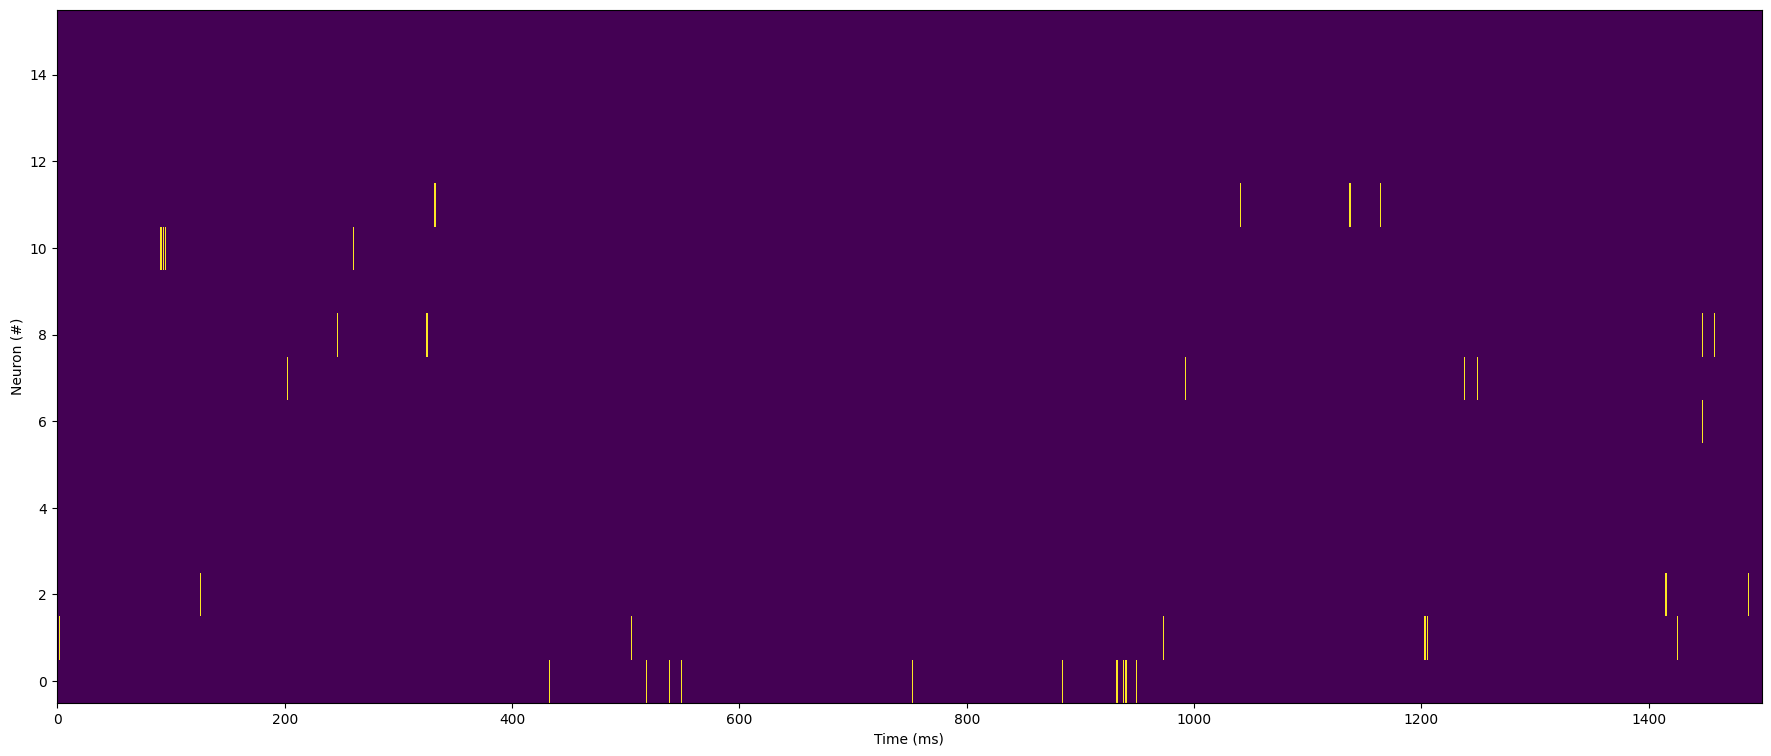

In [13]:
fig, ax = plt.subplots(figsize=(22, 9))

rates = ax.matshow(binned_spikes_matrix[1,:,:],aspect="auto",origin='lower')

ax.xaxis.tick_bottom()
ax.xaxis.set_label_position('bottom')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Neuron (#)')

In [14]:
def convolve_raster(binned_spikes):
    #Convolve a matrix containing the raster plots (time histogram of spikes) for all neurons in all trials

    #INPUT:
    # - binned_spikes: a trials x neurons x timebins matrix
    # - width: the kernel width, in ms
    # - sd: I haven't figured it out exactly yet: lower values widen the kernel shape and larger ones sharpen it
    #the authors didn't call it SD, I am extrapolating from my knowledge on gaussian filtering (might be wrong)

    #OUTPUT:
    # - convolved [np.ndarray(int,int,float)]: a trials x neurons x timebins matrix of convolved spiking activity

    x = np.linspace(0,750,750) #750 ms in 750 points

    kernel = np.exp(-x/100)
    kernel = np.pad(kernel,(750,0),'constant') #center the kernel at 0

    #uncomment these to plot the kernel
    #plt.figure()
    #plt.title('Decaying exponential kernel')
    #plt.plot(np.arange(0,len(x)),decaying_exp)

    #uncomment these to plot evidence that the kernel drops to 1/e over the course of 100ms
    #plt.figure()
    #plt.title('Decaying exponential kernel')
    #plt.plot(np.arange(0,len(x)),decaying_exp)


    #create a matrix with the same dimensions as the binned rasters' to accommodate the convolved rasters
    all_neurons_convolved = np.zeros(np.shape(binned_spikes))
    print(np.shape(all_neurons_convolved))

    #the # of trials, neurons and timebins are given by:
    trials,neurons,timebins = np.shape(binned_spikes)

    for trial in range(trials):
        for neuron in range(neurons):
            all_neurons_convolved[trial,neuron,:] = np.convolve(kernel,binned_spikes[trial,neuron,:]
                                                            ,mode='full')[750:-749]

    return all_neurons_convolved

In [15]:
firing_rates = convolve_raster(binned_spikes_matrix)

(47, 16, 1500)


Text(0, 0.5, 'Neuron (#)')

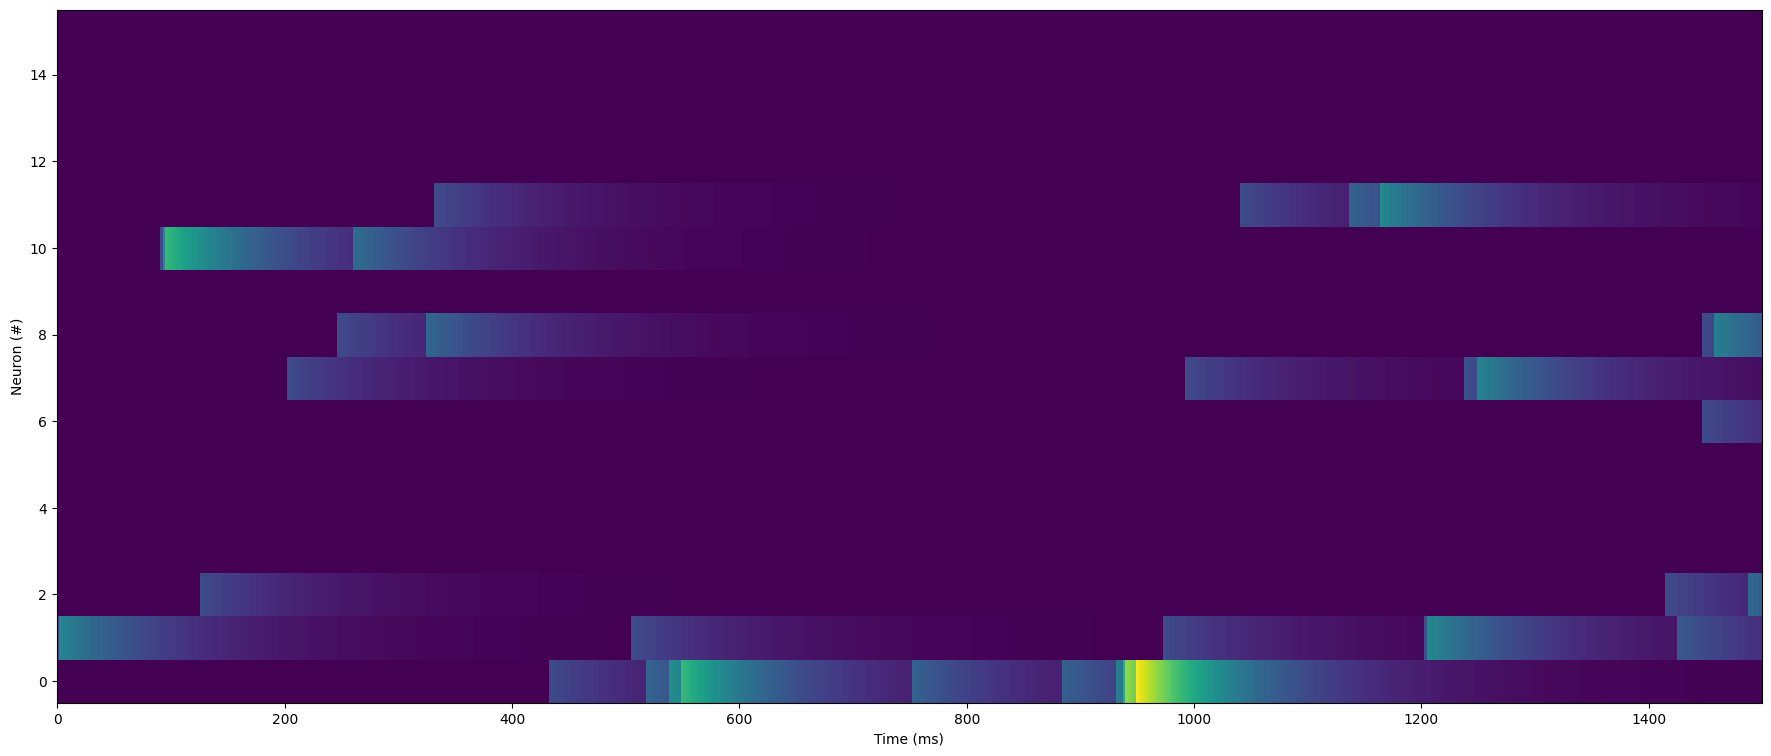

In [16]:
fig, ax = plt.subplots(figsize=(22, 9))

rates = ax.matshow(firing_rates[1,:,:],aspect="auto",origin='lower')

ax.xaxis.tick_bottom()
ax.xaxis.set_label_position('bottom')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Neuron (#)')

In [17]:
np.shape(firing_rates)

(47, 16, 1500)

In [18]:
(num_events,num_neurons,num_timebins) = np.shape(firing_rates)

In [19]:
third_of_events = int(num_events/3)

lowres_timebin_size = 100 #in ms

lowres_timebins = int(num_timebins/lowres_timebin_size)

In [20]:
early = firing_rates[0:third_of_events,:,:]
late = firing_rates[-third_of_events:,:,:]

In [21]:
averaged_early = np.mean(early,axis=0)
averaged_late = np.mean(late,axis=0)

In [22]:
def lower_firing_rate_resolution(spike_activity_matrix,time_window_size=100):

  '''
  Lower the resolution of a firing rate matrix with dimensions neurons x time bins by averaging over a window

  INPUT:
  - spike_activity_matrix [NumPy ndarray]: a 2D ndarray with dimensions neurons x time, in which each element (i,j) of the matrix represents the firing rate of neuron i at the j-th time bin
  - time_window_size [int]: time window over which the firing rates will be averaged (in ms)

  OUTPUT:
  - lowres_activity_matrix [NumPy ndarray]: a 2D ndarray with dimensions neurons x low_restime_bins, in which each element (i,j) of the matrix
                                            represents the firing rate of neuron i at the j-th low resolution time bin (by default of 100 ms width)
  '''

  (num_neurons,num_timebins) = np.shape(spike_activity_matrix)

  lowres_timebins = int(num_timebins/time_window_size)

  lowres_activity_matrix = np.zeros([num_neurons,lowres_timebins])

  for time_bin in range(lowres_timebins):
    lowres_activity_matrix[:,time_bin] = np.mean(spike_activity_matrix[:,time_bin*100:(time_bin+1)*100],axis=1)

  return lowres_activity_matrix

In [23]:
lowres_averaged_early = lower_firing_rate_resolution(averaged_early)
lowres_averaged_late = lower_firing_rate_resolution(averaged_late)

In [24]:
#uncomment to plot the early and late low-resolution firing rate matrices

'''plt.matshow(lowres_averaged_early)
plt.show()

plt.matshow(lowres_averaged_late)
plt.show()''';

Text(0, 0.5, 'Neuron (#)')

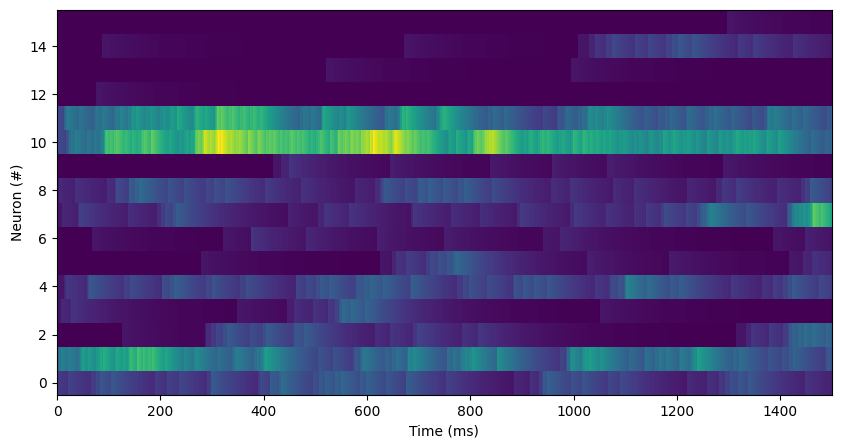

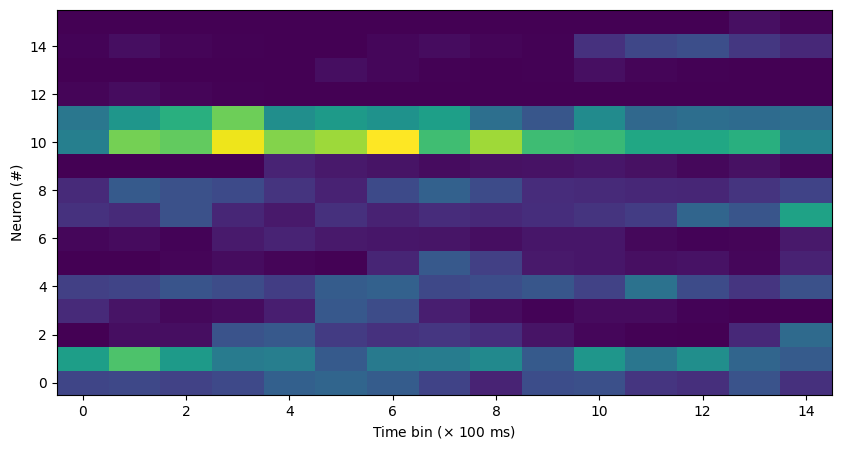

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))

rates = ax.matshow(averaged_early,aspect="auto",origin='lower')

ax.xaxis.tick_bottom()
ax.xaxis.set_label_position('bottom')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Neuron (#)')


fig, ax = plt.subplots(figsize=(10, 5))

rates = ax.matshow(lowres_averaged_early,aspect="auto",origin='lower')

ax.xaxis.tick_bottom()
ax.xaxis.set_label_position('bottom')
ax.set_xlabel(r'Time bin ($\times$ 100 ms)')
ax.set_ylabel('Neuron (#)')

[ 1.38777878e-16  2.49800181e-16  5.55111512e-17 -4.71844785e-16
  4.99600361e-16  3.88578059e-16 -4.99600361e-16 -8.32667268e-17
  8.60422844e-16  2.77555756e-16  2.77555756e-17 -5.55111512e-17
  6.38378239e-16 -1.11022302e-16 -1.94289029e-16]


Text(0, 0.5, 'Neuron (#)')

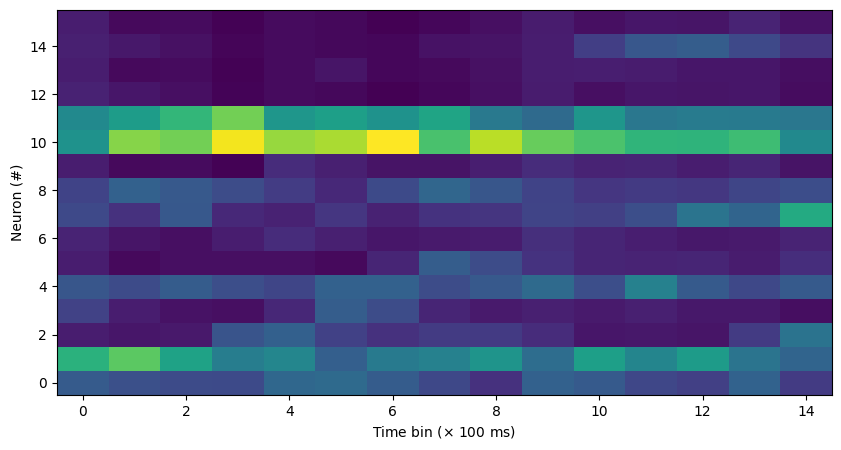

In [25]:
#Z-scoring so each column sums up to 0
Z_lowres_avg_early = lowres_averaged_early - lowres_averaged_early.mean(axis=0, keepdims=True)

print(np.sum(Z_lowres_avg_early,axis=0)) #attesting to that: almost all are near zero up to the numerical precision


fig, ax = plt.subplots(figsize=(10, 5))

rates = ax.matshow(Z_lowres_avg_early,aspect="auto",origin='lower')

ax.xaxis.tick_bottom()
ax.xaxis.set_label_position('bottom')
ax.set_xlabel(r'Time bin ($\times$ 100 ms)')
ax.set_ylabel('Neuron (#)')

In [90]:
def participation_ratio(spike_activity_matrix):
  '''
  Obtain the participation ratio of neurons (see Ganguli et al., 2017, https://doi.org/10.1101/214262) from a Z-scored activity matrix with its firing rates over time

  INPUT:
  - spike_activity_matrix [NumPy ndarray]: a 2D ndarray with dimensions neurons x time, in which each element (i,j) of the matrix represents the firing rate of neuron i at the j-th time bin
  OUTPUT:
  - participation_ratio [float]: a real value bound beetween [1,M] (M is the number of neurons) describing the number of dimensions required to describe the population activity
  '''

  #if the matrix has been normalized (the sum over columns differ from zero) then normalize it by subtracting the average of each neuron from all of its time bins
  if not np.isclose(np.sum(spike_activity_matrix,axis=0),np.zeros(len(np.sum(spike_activity_matrix,axis=0)))).all():
    #Z-scoring so each column sums up to 0
    spike_activity_matrix = spike_activity_matrix - spike_activity_matrix.mean(axis=0, keepdims=True)

  #Estimate the covariance
  #cov = spike_activity_matrix.T @ spike_activity_matrix / len(spike_activity_matrix)
  cov = np.cov(spike_activity_matrix)

  (L, P) = np.linalg.eigh(cov) #(eigenvalues, eigenvectors) of the covariance matrix yield the directions of most variance (e.g. firing patterns encompassing multiple neurons)

  #estimate the dimensionality
  participation_ratio = (np.sum(L))**2/np.sum([eigenvalue**2 for eigenvalue in L])

  return participation_ratio

In [27]:
participation_ratio(lowres_averaged_early),participation_ratio(lowres_averaged_late)

(1.268612279463558, 1.1336155336875313)

# Participation ratio early and late in session (using trials' data)
Spikes from each trial are convolved and then averaged over 1/3 of trials. This average spiking activity is time windowed, z-scored and therefrom a covariance matrix is built. The participation ratio is estimated from the eigenvalues of this covariance matrix.

In [91]:
def time_binning(spikes_df,timespan=[0,1.5]):

  #Transform the spikes DataFrame into a 3D np.ndarray whose dimensions are (trials,neurons,timebins)

  # INPUT:
  # - dataset [pandas DataFrame]
  # - timespan [list(float)]: the timestamp boundaries in which all spikes to be binned lie within (in s; default = [0s,1.5s])

  # OUTPUT:
  # - binned_spikes: a trials x neurons x timebins matrix

  #just in case the dataset is not sorted by trial
  dataset = spikes_df.sort_values('trial').copy()

  num_trials = dataset.trial.nunique()
  num_neurons = dataset.neuron.nunique()

  duration = timespan[1] - timespan[0]
  num_timebins = int(duration*1000)

  binned_spikes_matrix = np.zeros([num_trials,num_neurons,num_timebins])

  for trial_id,trial in enumerate(dataset.trial.unique()):
    for neuron_id,neuron in enumerate(dataset.neuron.unique()):
      spike_train = dataset.loc[(dataset['trial'] == trial) & (dataset['neuron'] == neuron)]
      discretized_spike_train,edges = np.histogram(spike_train.time,bins = np.linspace(timespan[0],timespan[1],num_timebins+1,endpoint=True))
      binned_spikes_matrix[trial_id,neuron_id,:] = discretized_spike_train

  return binned_spikes_matrix

def convolve_raster(binned_spikes):
    #Convolve a matrix containing the raster plots (time histogram of spikes) for all neurons in all trials

    #INPUT:
    # - binned_spikes: a trials x neurons x timebins matrix
    # - width: the kernel width, in ms
    # - sd: I haven't figured it out exactly yet: lower values widen the kernel shape and larger ones sharpen it
    #the authors didn't call it SD, I am extrapolating from my knowledge on gaussian filtering (might be wrong)

    #OUTPUT:
    # - convolved [np.ndarray(int,int,float)]: a trials x neurons x timebins matrix of convolved spiking activity

    x = np.linspace(0,750,750) #750 ms in 750 points

    kernel = np.exp(-x/100)
    kernel = np.pad(kernel,(750,0),'constant') #center the kernel at 0

    #uncomment these to plot the kernel
    #plt.figure()
    #plt.title('Decaying exponential kernel')
    #plt.plot(np.arange(0,len(x)),decaying_exp)

    #uncomment these to plot evidence that the kernel drops to 1/e over the course of 100ms
    #plt.figure()
    #plt.title('Decaying exponential kernel')
    #plt.plot(np.arange(0,len(x)),decaying_exp)


    #create a matrix with the same dimensions as the binned rasters' to accommodate the convolved rasters
    all_neurons_convolved = np.zeros(np.shape(binned_spikes))
    print(np.shape(all_neurons_convolved))

    #the # of trials, neurons and timebins are given by:
    trials,neurons,timebins = np.shape(binned_spikes)

    for trial in range(trials):
        for neuron in range(neurons):
            all_neurons_convolved[trial,neuron,:] = np.convolve(kernel,binned_spikes[trial,neuron,:]
                                                            ,mode='full')[750:-749]

    return all_neurons_convolved


In [92]:
def separate_rats(dataframe,check_num_neurons=True,min_num_neurons = 2):
    #Separate the dataframe by rat, and store each part as an entry in a list

    # INPUT:
    # - dataframe
    # - check_num_neurons: check whether a rat in this dataframe has less than min_num_neurons (default: True)
    # - min_num_neurons: the least amount of neurons an animal has to have in order to be included (default: 2)

    # OUTPUT:
    # - rats: a list of DataFrames, each entry being the subset of the main DataFrame with the spikes from one rat

    rats = []
    for rat in dataframe['rat'].unique():

        #Check whether a rat has only one registered neuron in the dataset
        if check_num_neurons:
            if dataframe.loc[dataframe['rat']==rat].neuron.nunique() < min_num_neurons:
                #If it's less than min_num_neurons, skip to the next animal
                continue
            #If one's not checking (check_num_neurons = False) or the animal has sufficient neurons, save it
        rats.append(dataframe.loc[dataframe['rat'] == rat])
    return rats #an array of dataframes (!)

def least_amount_neurons(dataset,num_cells_threshold = 4):
    #Drop trials with less than a given amount of neurons out of the dataset and find the least amount of units among all remaining trials that is not below this threshold

    #INPUT:
    # - dataset: pandas DataFrame [pd.df] (for columns and descriptions: see _specifications_)
    # - num_cells_threshold: the least amount of neurons required for inclusion of that trial

    #OUTPUT:
    # - pruned_dataset: the dataset (pd.df) cleared of the data pertaining to trials with less neurons than needed
    # - min_num_units: the minimum number of neurons all the remaining cells possess

    #Make a copy, so it'll not alter the given dataset
    pruned_dataset = dataset.copy()

    #Set the minimum amount of neurons to a high initial value
    min_num_units = 10_000 #a ludicrous amount of neurons

    #Check each trial for their number of neurons
    for trial in dataset.trial.unique():
        #if it falls below the threshold, remove it from the pruned_dataset
        if dataset.loc[dataset['trial'] == trial].neuron.nunique() < num_cells_threshold:
            pruned_dataset.drop(pruned_dataset.loc[pruned_dataset['trial']==trial].index,inplace=True)
            pass #skip to the next trial, so not to alter min_num_units with this trial

        #if it is not lower than this least amount, check if it is less than what was set to be the minimum so far
        elif dataset.loc[dataset['trial'] == trial].neuron.nunique() < min_num_units:
            min_num_units = dataset.loc[dataset['trial'] == trial].neuron.nunique()

    return pruned_dataset,min_num_units

def least_amount_spikes(dataset,num_spikes_threshold = 4):
    #Drop trials with less than a given amount of spikes out of the dataset

    #INPUT:
    # - dataset: pandas DataFrame [pd.df] (for columns and descriptions: see _specifications_)
    # - num_spikes_threshold: the least amount of neurons required for inclusion of that trial

    #OUTPUT:
    # - pruned_dataset: the dataset (pd.df) cleared of the data pertaining to trials with less spikes than required

    #Make a copy, so it'll not alter the given dataset
    pruned_dataset = dataset.copy()

    #Check each trial for their number of neurons
    for trial in dataset.trial.unique():
        #if it falls below the threshold, remove it from the pruned_dataset
        if len(dataset.loc[dataset['trial'] == trial]) < num_spikes_threshold:
            pruned_dataset.drop(pruned_dataset.loc[pruned_dataset['trial']==trial].index,inplace=True)

    return pruned_dataset

In [93]:
def early_late_dimensionality_per_rat(separated_rats,group,day,region,num_bins = 15):
  dimensionality_results_early = []
  dimensionality_results_late = []
  rats_ids = []

  least_amount_of_trials = min([animal.trial.nunique() for animal in separated_rats])
  trials_in_thirds = int(least_amount_of_trials/3)

  for animal in separated_rats:
      #Get the animal's label to later identify it in the DataFrame
      animal_label = animal.rat.unique()[0]
      print('Beginning the analyses for the rat: ',animal_label)

      animal_pruned = least_amount_spikes(animal,num_spikes_threshold=5)
      current_num_neurons = animal_pruned.neuron.nunique()

      print(animal_pruned.trial.nunique())

      binned_spikes = time_binning(animal_pruned)
      convolved_spikes = convolve_raster(binned_spikes)

      #average over the first and last third of trials
      averaged_early = np.mean(convolved_spikes[0:trials_in_thirds,:,:],axis=0)
      averaged_late = np.mean(convolved_spikes[-trials_in_thirds:,:,:],axis=0)

      #lower the time resolution (from 1 ms resolution to 100 ms resolution by averaging over this 100 ms window)
      lowres_averaged_early = lower_firing_rate_resolution(averaged_early)
      lowres_averaged_late = lower_firing_rate_resolution(averaged_late)

      participation_ratio_early = participation_ratio(lowres_averaged_early)
      participation_ratio_late = participation_ratio(lowres_averaged_late)

      print(participation_ratio_early)
      print(participation_ratio_late)

      dimensionality_results_early.append(participation_ratio_early)
      dimensionality_results_late.append(participation_ratio_late)

      rats_ids.append(animal_label)

  early_tags = ['early' for i in range(len(separated_rats))]
  late_tags = ['late' for i in range(len(separated_rats))]

  all_tags = early_tags+late_tags

  df = pd.DataFrame({'participation_ratio':dimensionality_results_early+dimensionality_results_late,'animal_id':rats_ids*2,'session_part':all_tags,'group':group,'day':day,'region':region})

  return df

In [94]:
def query_session(spikes_dataframe,group,day,region,filter_trials_between=[1.5,3.5],peri_trial_interval=-0.5):
  data_subset = spikes_dataframe.query(f'group == {group} and day == {day} and region == "{region}" and duration >= {filter_trials_between[0]} and duration <= {filter_trials_between[1]}' +
                                       f'and time >= {peri_trial_interval} and time <= {filter_trials_between[0]}').copy()

  return data_subset

data = session_data.copy()

######## Group 1, day 1 ###########

separated_rats = separate_rats(query_session(data,group=1,day=1,region='PFC'),check_num_neurons=True,min_num_neurons = 4)
g1d1_PFC = early_late_dimensionality_per_rat(separated_rats,group=1,region='PFC',day=1)

######## Group 2, day 1 ###########
separated_rats = separate_rats(query_session(data,group=2,day=1,region='PFC'),check_num_neurons=True,min_num_neurons = 4)
g2d1_PFC = early_late_dimensionality_per_rat(separated_rats,group=2,region='PFC',day=1)

separated_rats = separate_rats(query_session(data,group=2,day=1,region='STR'),check_num_neurons=True,min_num_neurons = 4)
g2d1_STR = early_late_dimensionality_per_rat(separated_rats,group=2,region='STR',day=1)


######## Group 2, day 2 ###########
separated_rats = separate_rats(query_session(data,group=2,day=2,region='PFC'),check_num_neurons=True,min_num_neurons = 4)
g2d2_PFC = early_late_dimensionality_per_rat(separated_rats,group=2,region='PFC',day=2)

separated_rats = separate_rats(query_session(data,group=2,day=2,region='STR'),check_num_neurons=True,min_num_neurons = 4)
g2d2_STR = early_late_dimensionality_per_rat(separated_rats,group=2,region='STR',day=2)

both_days_both_regions_df = pd.concat([g1d1_PFC,g2d1_PFC,g2d1_STR,g2d2_PFC,g2d2_STR])

Beginning the analyses for the rat:  7
603
(603, 17, 1500)
1.1365520974532535
1.6421341348454057
Beginning the analyses for the rat:  8
407
(407, 35, 1500)
1.4627812742642854
1.4202067241471696
Beginning the analyses for the rat:  9
362
(362, 10, 1500)
1.5986475942990395
1.794153654257322
Beginning the analyses for the rat:  10
850
(850, 9, 1500)
1.3512265762607298
2.076368025841415
Beginning the analyses for the rat:  3
262
(262, 4, 1500)
1.6895211325114756
2.1778548874762413
Beginning the analyses for the rat:  4
182
(182, 33, 1500)
2.9636699093364305
3.4393861709648115
Beginning the analyses for the rat:  5
108
(108, 5, 1500)
1.2888259738518806
1.4367350076595793
Beginning the analyses for the rat:  6
385
(385, 4, 1500)
1.3380341000597937
1.2691836071482394
Beginning the analyses for the rat:  3
262
(262, 12, 1500)
1.2324698481722292
1.3130227734049889
Beginning the analyses for the rat:  4
182
(182, 26, 1500)
2.050402937080775
1.4290036981179455
Beginning the analyses for the rat: 

In [95]:
both_days_both_regions_df

,participation_ratio,animal_id,session_part,group,day,region
0,1.136552,7,early,1,1,PFC
1,1.462781,8,early,1,1,PFC
2,1.598648,9,early,1,1,PFC
3,1.351227,10,early,1,1,PFC
4,1.642134,7,late,1,1,PFC
5,1.420207,8,late,1,1,PFC
6,1.794154,9,late,1,1,PFC
7,2.076368,10,late,1,1,PFC
0,1.689521,3,early,2,1,PFC
1,2.963670,4,early,2,1,PFC


In [96]:
import seaborn as sns

TtestResult(statistic=-2.989148016013507, pvalue=0.02025075923054107, df=7)


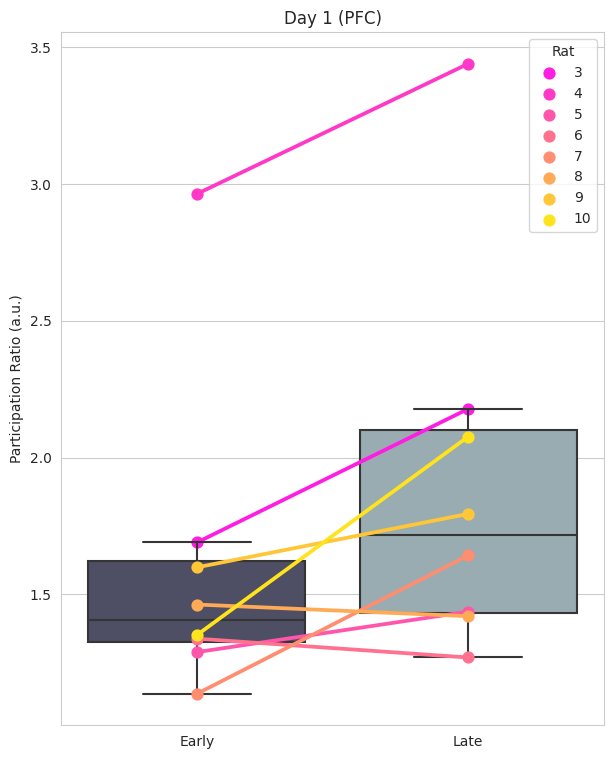

In [97]:
#column name, plot name for column, color scheme
variable_of_interest = ['participation_ratio','Participation Ratio','spring']

#plots:
#PFC day 1 (early, late)
current = both_days_both_regions_df.query('region == "PFC" and day == 1')

plt.figure(figsize=(7,9))
#sns.set_style("darkgrid")
sns.set_style("whitegrid")
sns.boxplot(data = current,x=current['session_part'].values,y=current[variable_of_interest[0]].values,palette = 'bone')
sns.pointplot(data = current,x=current['session_part'].values,y=current[variable_of_interest[0]].values,hue=current['animal_id'].values,palette = variable_of_interest[2])
plt.title('Day 1 (PFC)')
plt.xticks(plt.xticks()[0],['Early','Late'])
plt.ylabel(f'{variable_of_interest[1]} (a.u.)')
plt.legend(title='Rat')

import scipy.stats as stats

pre = current.query('session_part == "early"')[variable_of_interest[0]].values
post = current.query('session_part == "late"')[variable_of_interest[0]].values

# Performing the paired sample t-test
print(stats.ttest_rel(pre, post))

# Scree plots from every session

In [87]:
def scree_plot(spike_activity_matrix,plotting_axis,points_label=None,points_symbol='o'):
  '''
  Plot a scree plot from the eigenvalues of the covariance matrix from the spike activity

  INPUT:
  - spike_activity_matrix [NumPy ndarray]: a 2D ndarray with dimensions neurons x time, in which each element (i,j) of the matrix represents the firing rate of neuron i at the j-th time bin
  OUTPUT:
  None
  '''

  #if the matrix has been normalized (the sum over columns differ from zero) then normalize it by subtracting the average of each neuron from all of its time bins
  if not np.isclose(np.sum(spike_activity_matrix,axis=0),np.zeros(len(np.sum(spike_activity_matrix,axis=0)))).all():
    #Z-scoring so each column sums up to 0
    spike_activity_matrix = spike_activity_matrix - spike_activity_matrix.mean(axis=0, keepdims=True)

  #Estimate the covariance
  #cov = spike_activity_matrix @ spike_activity_matrix.T / len(spike_activity_matrix)
  cov = np.cov(spike_activity_matrix)

  (L, P) = np.linalg.eigh(cov) #(eigenvalues, eigenvectors) of the covariance matrix yield the directions of most variance (e.g. firing patterns encompassing multiple neurons)

  #Order the eigenvalues from greatest to lowest in magnitude
  idx = L.argsort()[::-1]
  L = L[idx]
  P = P[:,idx]

  plotting_axis.plot(np.cumsum(L)/np.sum(L), points_symbol,label=points_label)
  plotting_axis.set_xlabel('Eigenvalue index')
  plotting_axis.set_ylabel('Cumulative explained variance')

In [88]:
def early_late_scree_plots_per_rat(separated_rats,group,day,region,num_bins = 15):
  dimensionality_results_early = []
  dimensionality_results_late = []
  rats_ids = []

  least_amount_of_trials = min([animal.trial.nunique() for animal in separated_rats])
  trials_in_thirds = int(least_amount_of_trials/3)

  for animal in separated_rats:
      #Get the animal's label to later identify it in the DataFrame
      animal_label = animal.rat.unique()[0]
      print('Beginning the analyses for the rat: ',animal_label)

      animal_pruned = least_amount_spikes(animal,num_spikes_threshold=5)
      current_num_neurons = animal_pruned.neuron.nunique()

      print(animal_pruned.trial.nunique())

      binned_spikes = time_binning(animal_pruned)
      convolved_spikes = convolve_raster(binned_spikes)

      #average over the first and last third of trials
      averaged_early = np.mean(convolved_spikes[0:trials_in_thirds,:,:],axis=0)
      averaged_late = np.mean(convolved_spikes[-trials_in_thirds:,:,:],axis=0)

      #lower the time resolution (from 1 ms resolution to 100 ms resolution by averaging over this 100 ms window)
      lowres_averaged_early = lower_firing_rate_resolution(averaged_early)
      lowres_averaged_late = lower_firing_rate_resolution(averaged_late)

      fig, ax = plt.subplots(figsize=(10,5))

      scree_plot(lowres_averaged_early,ax,points_label = 'Early trials',points_symbol='o')
      scree_plot(lowres_averaged_late,ax,points_label = 'Late trials',points_symbol='*')
      plt.legend()
      plt.show()

Beginning the analyses for the rat:  7
603
(603, 17, 1500)


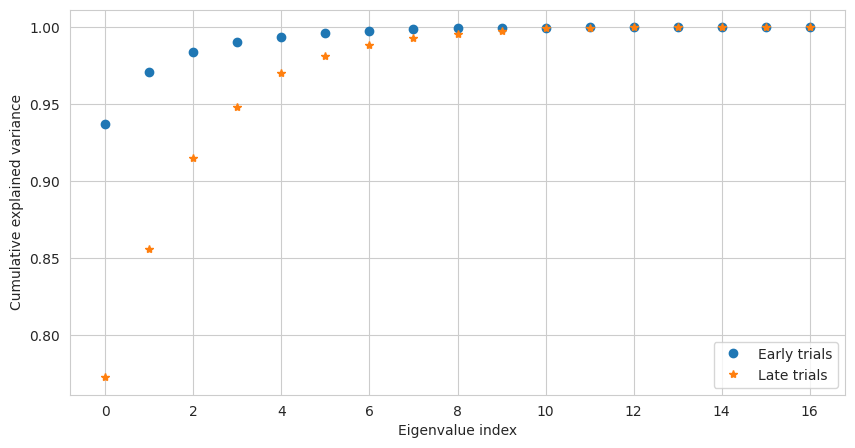

Beginning the analyses for the rat:  8
407
(407, 35, 1500)


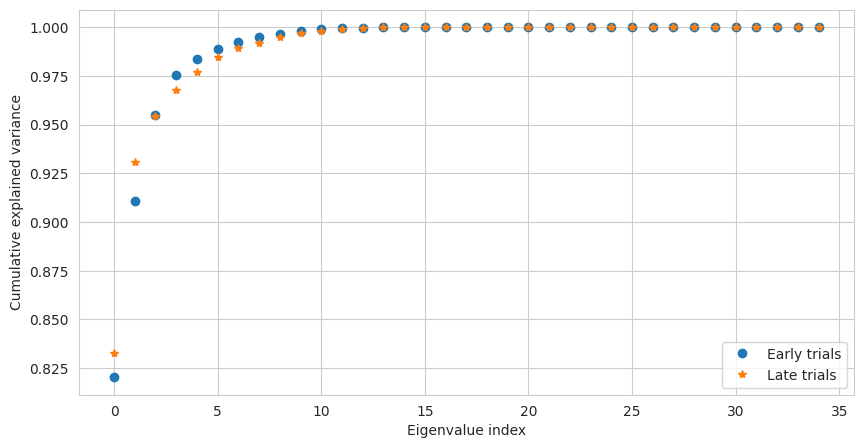

Beginning the analyses for the rat:  9
362
(362, 10, 1500)


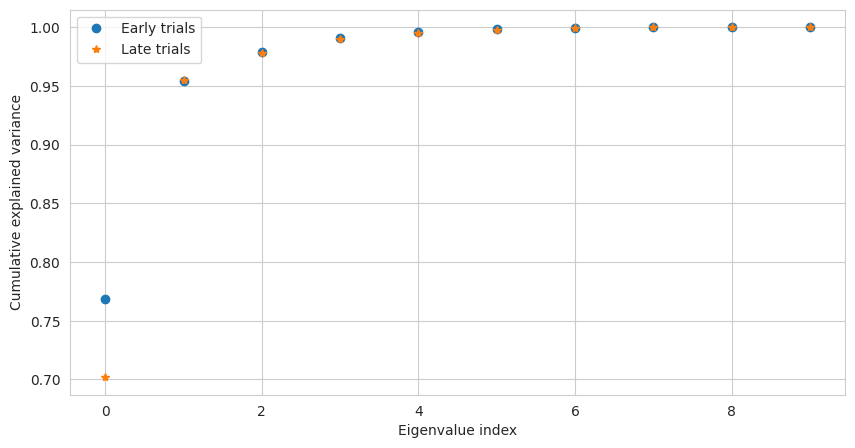

Beginning the analyses for the rat:  10
850
(850, 9, 1500)


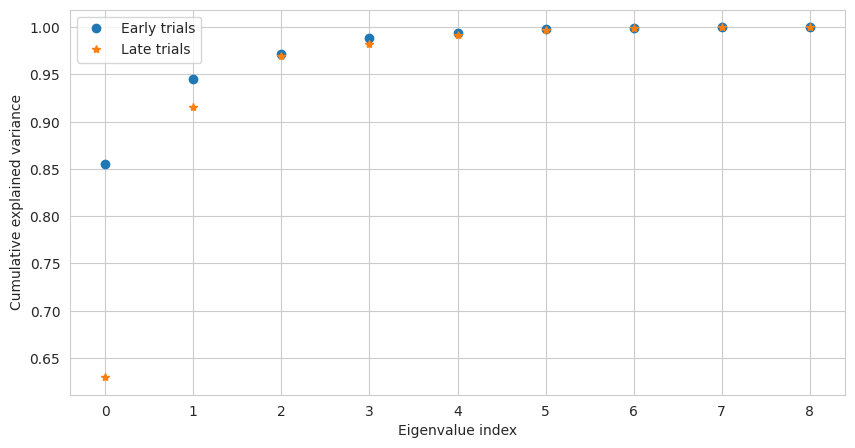

Beginning the analyses for the rat:  3
262
(262, 4, 1500)


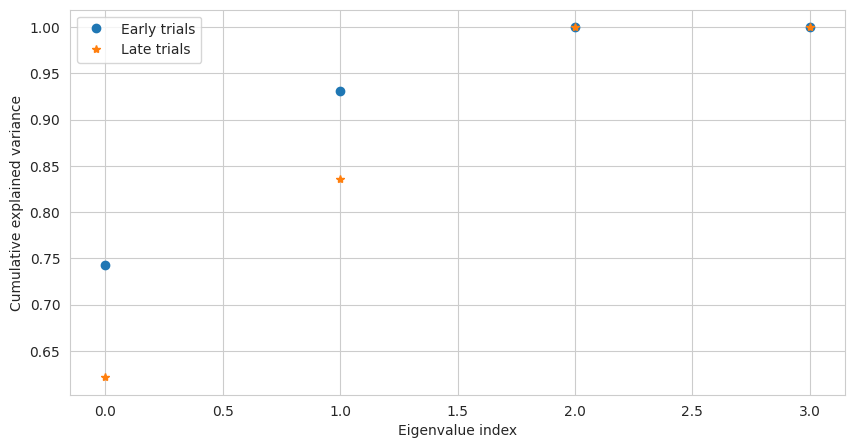

Beginning the analyses for the rat:  4
182
(182, 33, 1500)


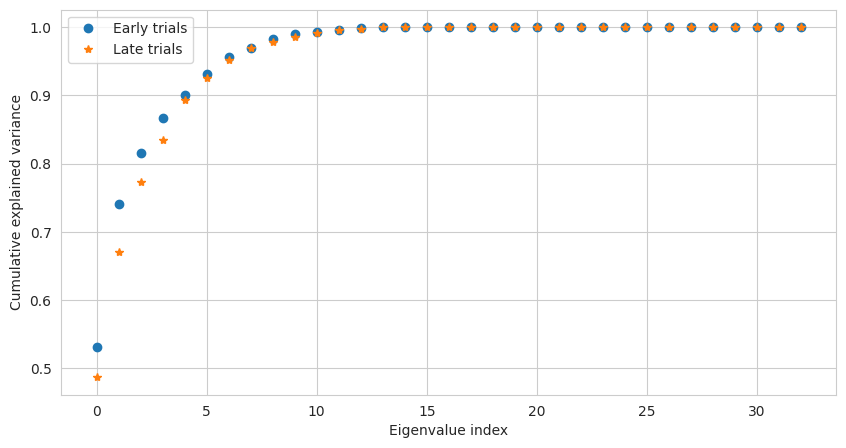

Beginning the analyses for the rat:  5
108
(108, 5, 1500)


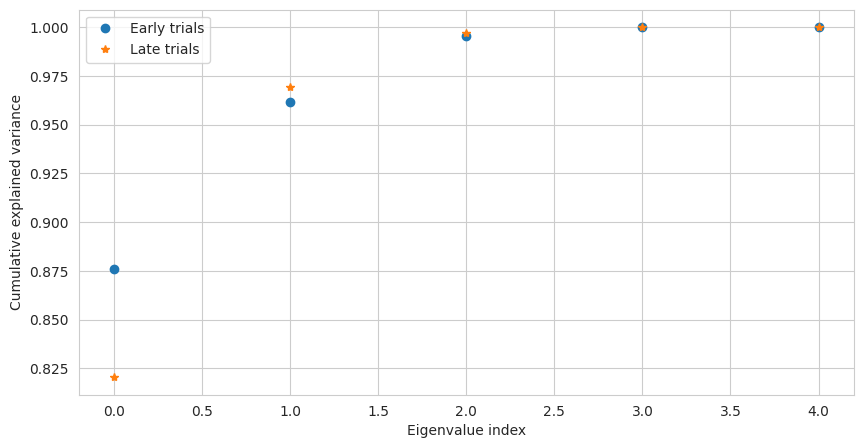

Beginning the analyses for the rat:  6
385
(385, 4, 1500)


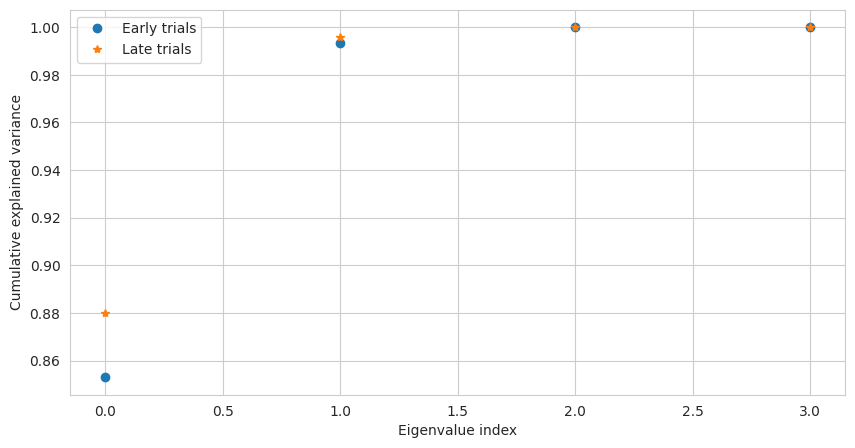

Beginning the analyses for the rat:  3
262
(262, 12, 1500)


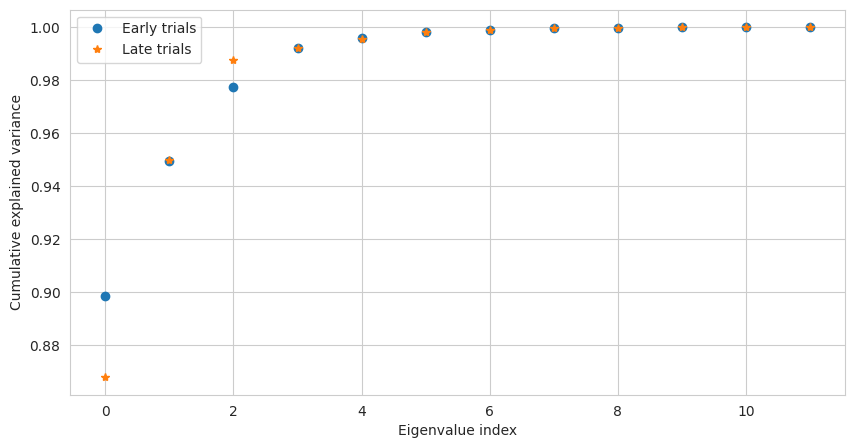

Beginning the analyses for the rat:  4
182
(182, 26, 1500)


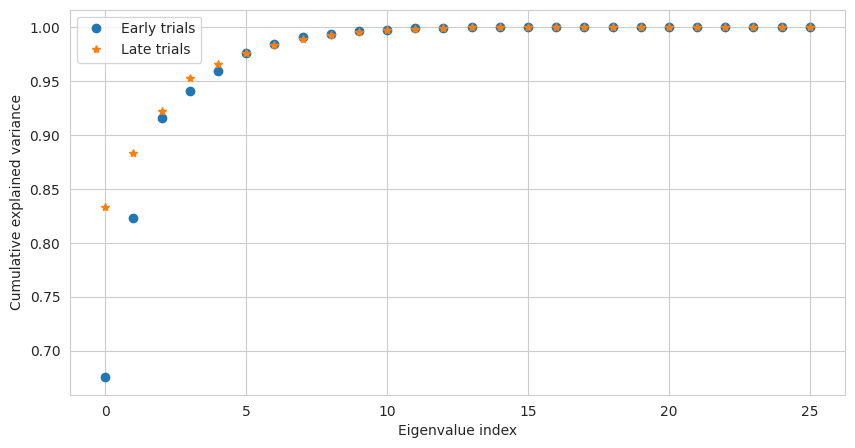

Beginning the analyses for the rat:  5
147
(147, 16, 1500)


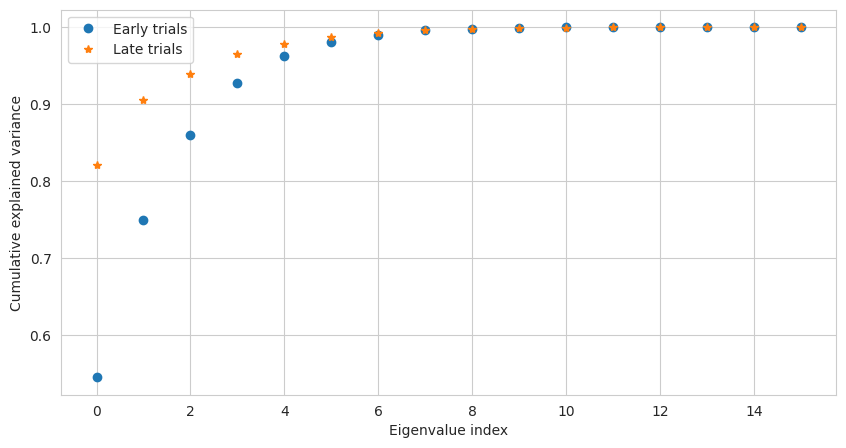

Beginning the analyses for the rat:  3
398
(398, 14, 1500)


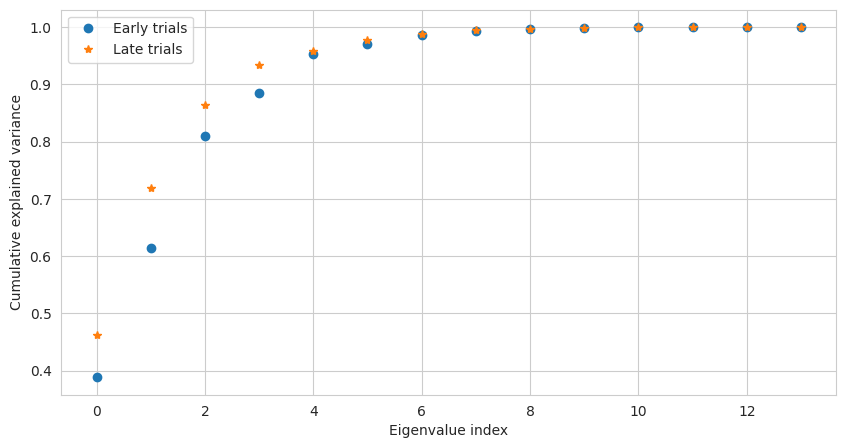

Beginning the analyses for the rat:  4
175
(175, 28, 1500)


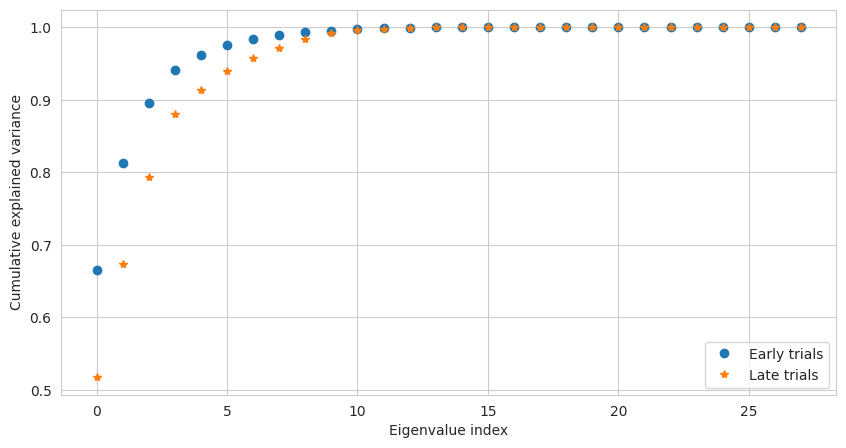

Beginning the analyses for the rat:  5
186
(186, 5, 1500)


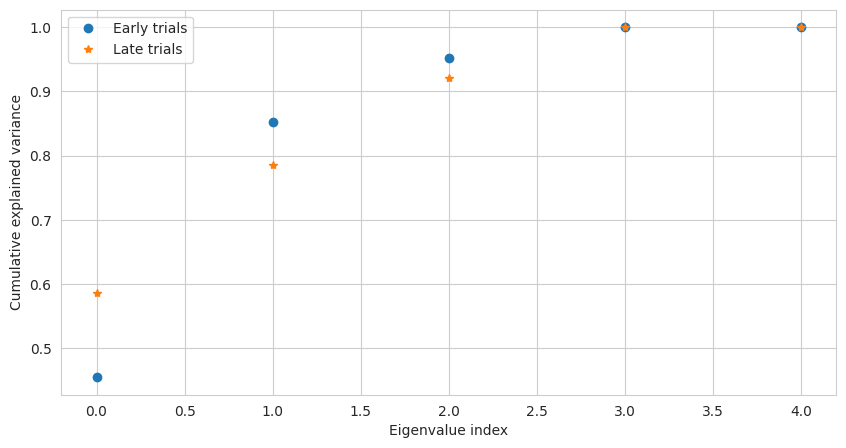

Beginning the analyses for the rat:  3
398
(398, 16, 1500)


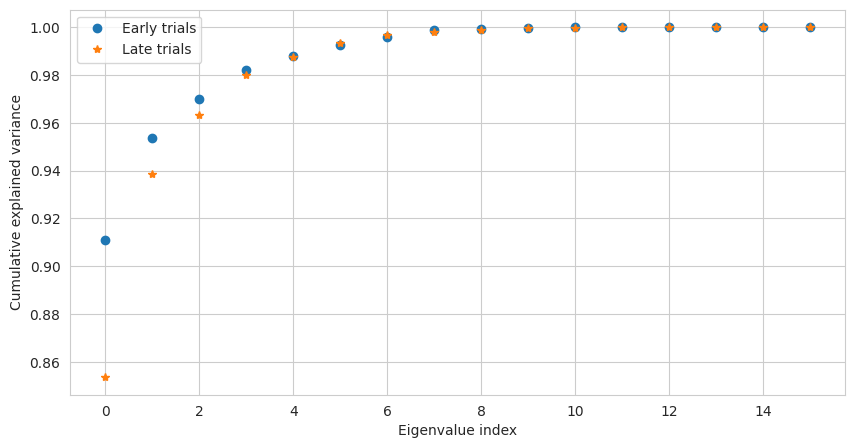

Beginning the analyses for the rat:  4
175
(175, 16, 1500)


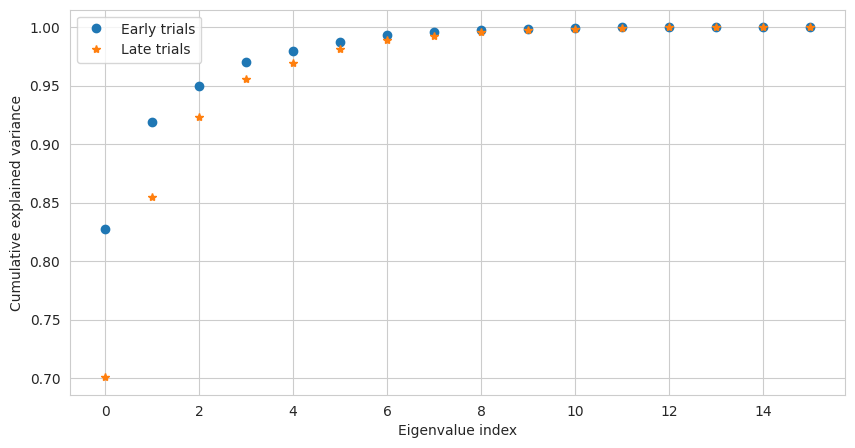

Beginning the analyses for the rat:  5
192
(192, 23, 1500)


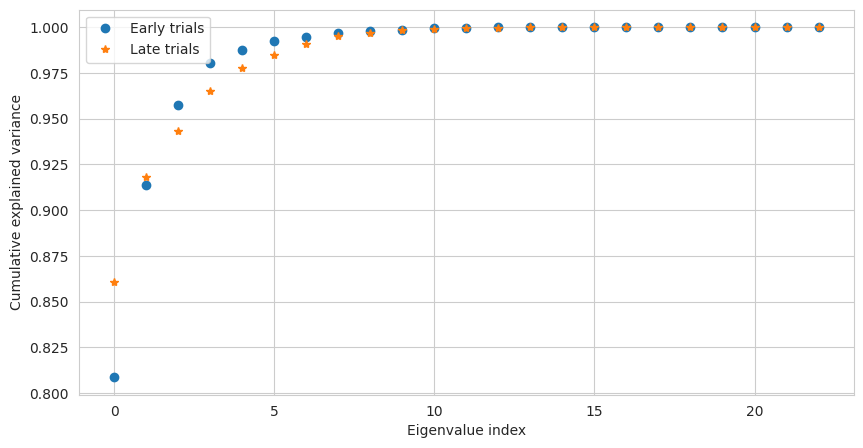

Beginning the analyses for the rat:  6
371
(371, 5, 1500)


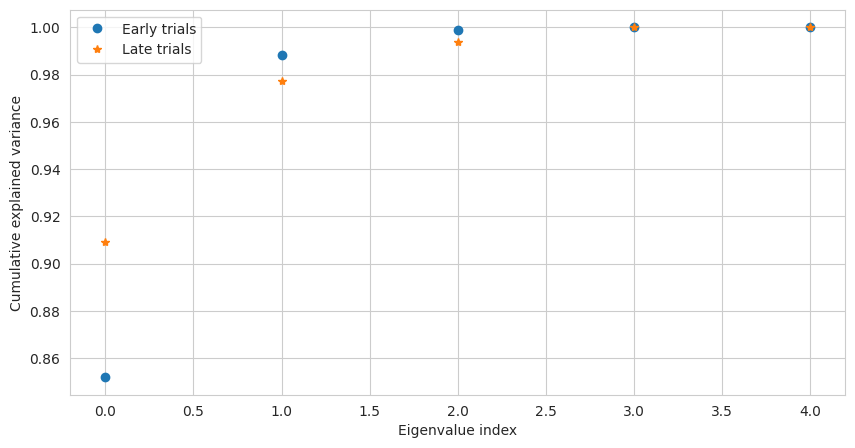

In [89]:
def query_session(spikes_dataframe,group,day,region,filter_trials_between=[1.5,3.5],peri_trial_interval=-0.5):
  data_subset = spikes_dataframe.query(f'group == {group} and day == {day} and region == "{region}" and duration >= {filter_trials_between[0]} and duration <= {filter_trials_between[1]}' +
                                       f'and time >= {peri_trial_interval} and time <= {filter_trials_between[0]}').copy()

  return data_subset

data = session_data.copy()

######## Group 1, day 1 ###########

separated_rats = separate_rats(query_session(data,group=1,day=1,region='PFC'),check_num_neurons=True,min_num_neurons = 4)
g1d1_PFC = early_late_scree_plots_per_rat(separated_rats,group=1,region='PFC',day=1)

######## Group 2, day 1 ###########
separated_rats = separate_rats(query_session(data,group=2,day=1,region='PFC'),check_num_neurons=True,min_num_neurons = 4)
g2d1_PFC = early_late_scree_plots_per_rat(separated_rats,group=2,region='PFC',day=1)

separated_rats = separate_rats(query_session(data,group=2,day=1,region='STR'),check_num_neurons=True,min_num_neurons = 4)
g2d1_STR = early_late_scree_plots_per_rat(separated_rats,group=2,region='STR',day=1)


######## Group 2, day 2 ###########
separated_rats = separate_rats(query_session(data,group=2,day=2,region='PFC'),check_num_neurons=True,min_num_neurons = 4)
g2d2_PFC = early_late_scree_plots_per_rat(separated_rats,group=2,region='PFC',day=2)

separated_rats = separate_rats(query_session(data,group=2,day=2,region='STR'),check_num_neurons=True,min_num_neurons = 4)
g2d2_STR = early_late_scree_plots_per_rat(separated_rats,group=2,region='STR',day=2)

# cross correlation of spike trains (from convolved firing rates)

In [32]:
def time_binning(spikes_df,timespan=[0,1.5]):

  #Transform the spikes DataFrame into a 3D np.ndarray whose dimensions are (trials,neurons,timebins)

  # INPUT:
  # - dataset [pandas DataFrame]
  # - timespan [list(float)]: the timestamp boundaries in which all spikes to be binned lie within (in s; default = [0s,1.5s])

  # OUTPUT:
  # - binned_spikes: a trials x neurons x timebins matrix

  #just in case the dataset is not sorted by trial
  dataset = spikes_df.sort_values('stage_id').copy()

  num_stages = dataset.stage_id.nunique()
  num_neurons = dataset.neuron.nunique()

  duration = timespan[1] - timespan[0]

  num_timebins = int(duration*1000)

  binned_spikes_matrix = np.zeros([num_stages,num_neurons,num_timebins])


  for stage_id,stage in enumerate(dataset.stage_id.unique()):
    stage_beginning = dataset.loc[dataset['stage_id'] == stage].timestamp.min()
    for neuron_id,neuron in enumerate(dataset.neuron.unique()):
      spike_train = dataset.loc[(dataset['stage_id'] == stage) & (dataset['neuron'] == neuron)]
      discretized_spike_train,edges = np.histogram(spike_train.timestamp - stage_beginning,bins = np.linspace(timespan[0] - stage_beginning,timespan[1] - stage_beginning,num_timebins+1,endpoint=True))
      binned_spikes_matrix[stage_id,neuron_id,:] = discretized_spike_train
  return binned_spikes_matrix

In [ ]:
#Load the spikes' dataframe
scored_states_spikes = pd.read_csv('/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels//data/all_scored_states.csv')

In [ ]:
scored_states_spikes.sort_values('stage_duration')

,Unnamed: 0,timestamp,region,day,group,rat,neuron,stage,stage_id,stage_duration
50497,8,3513.942433,STR,1,2,3,6,NREMstate,16,2
26611,2,3513.182800,PFC,1,2,3,3,NREMstate,16,2
26610,1,3513.004633,PFC,1,2,3,3,NREMstate,16,2
26609,0,3512.291533,PFC,1,2,3,3,NREMstate,16,2
84626,0,3512.343167,PFC,1,2,3,8,NREMstate,16,2
...,...,...,...,...,...,...,...,...,...,...
10181194,331,3717.962867,STR,2,2,6,1,WAKEstate,6,4965
10181195,332,3718.684200,STR,2,2,6,1,WAKEstate,6,4965
10181196,333,3719.140533,STR,2,2,6,1,WAKEstate,6,4965
10181190,327,3715.120267,STR,2,2,6,1,WAKEstate,6,4965


In [ ]:
scored_states_spikes.query(f'rat == 3 and day == 1 and stage == "NREMstate"').sort_values('stage_duration').head(500)

,Unnamed: 0,timestamp,region,day,group,rat,neuron,stage,stage_id,stage_duration
121929,3,3512.671433,STR,1,2,3,13,NREMstate,16,2
26609,0,3512.291533,PFC,1,2,3,3,NREMstate,16,2
50498,9,3513.967633,STR,1,2,3,6,NREMstate,16,2
3277,0,3512.023500,PFC,1,2,3,0,NREMstate,16,2
103134,3,3512.619800,STR,1,2,3,12,NREMstate,16,2
...,...,...,...,...,...,...,...,...,...,...
17001,4,8488.878533,STR,1,2,3,2,NREMstate,18,6
17000,3,8488.825967,STR,1,2,3,2,NREMstate,18,6
16999,2,8488.772500,STR,1,2,3,2,NREMstate,18,6
16998,1,8488.705067,STR,1,2,3,2,NREMstate,18,6


In [ ]:
NREM_target_session = scored_states_spikes.query(f'rat == 3 and day == 1 and stage == "NREMstate"')
num_neurons = NREM_target_session.neuron.nunique()
num_periods = NREM_target_session.stage_id.nunique()

In [ ]:
correlation_matrices = np.zeros([num_periods,num_neurons,num_neurons])

In [ ]:
def time_binning2(spikes_df,num_neurons,timespan=[0,1.5]):

  #Transform the spikes DataFrame into a 3D np.ndarray whose dimensions are (trials,neurons,timebins)

  # INPUT:
  # - dataset [pandas DataFrame]
  # - timespan [list(float)]: the timestamp boundaries in which all spikes to be binned lie within (in s; default = [0s,1.5s])

  # OUTPUT:
  # - binned_spikes: a trials x neurons x timebins matrix

  #just in case the dataset is not sorted by trial
  dataset = spikes_df.sort_values('stage_id').copy()

  num_stages = dataset.stage_id.nunique()

  duration = timespan[1] - timespan[0]

  num_timebins = int(duration*1000)

  binned_spikes_matrix = np.zeros([num_stages,num_neurons,num_timebins])
  print(np.shape(binned_spikes_matrix))

  for stage_id,stage in enumerate(dataset.stage_id.unique()):
    stage_beginning = dataset.loc[dataset['stage_id'] == stage].timestamp.min()
    for neuron in dataset.neuron.unique():
      print(neuron)
      spike_train = dataset.loc[(dataset['stage_id'] == stage) & (dataset['neuron'] == neuron)]
      discretized_spike_train,edges = np.histogram(spike_train.timestamp - stage_beginning,bins = np.linspace(timespan[0] - stage_beginning,timespan[1] - stage_beginning,num_timebins+1,endpoint=True))
      binned_spikes_matrix[stage_id,neuron,:] = discretized_spike_train
  return binned_spikes_matrix

def symmetrize(a):
    """
    Return a symmetrized version of NumPy array a.

    Values 0 are replaced by the array value at the symmetric
    position (with respect to the diagonal), i.e. if a_ij = 0,
    then the returned array a' is such that a'_ij = a_ji.

    Diagonal values are left untouched.

    a -- square NumPy array, such that a_ij = 0 or a_ji = 0,
    for i != j.
    """
    return a + a.T - np.diag(a.diagonal())

In [ ]:
symmetrized_correlation_matrices = [symmetrize(correlation_matrices[i,:,:]) for i in range(np.shape(correlation_matrices)[0])]

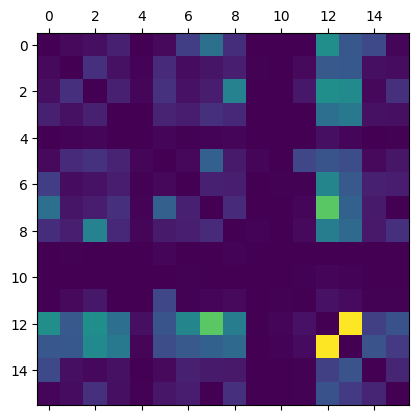

In [ ]:
plt.matshow(symmetrized_correlation_matrices[2])

In [ ]:
#shazam

from itertools import combinations

for period_id in NREM_target_session.stage_id.unique():
  period_spikes = NREM_target_session.query(f'stage_id == {period_id}')
  binned_period_spikes = time_binning2(spikes_df = period_spikes,num_neurons=num_neurons,timespan=[period_spikes.timestamp.min(),period_spikes.timestamp.max()])
  firing_rates = np.squeeze(convolve_raster(binned_period_spikes))

  for neuron1,neuron2 in combinations(range(num_neurons),2):
    correlation_between_pair = np.correlate(firing_rates[neuron1,:],firing_rates[neuron2,:])
    correlation_matrices[period_id,neuron1,neuron2] = correlation_between_pair

symmetrized_correlation_matrices = [symmetrize(correlation_matrices[i,:,:]) for i in range(np.shape(correlation_matrices)[0])]
average_correlation_over_periods = np.mean(symmetrized_correlation_matrices,axis=0)

(1, 16, 13780)
0
12
13
8
9
14
3
2
5
1
7
6
(1, 16, 13780)
(1, 16, 86885)
0
12
13
9
8
11
10
14
15
2
1
3
7
6
5
4
(1, 16, 86885)
(1, 16, 27951)
0
12
13
11
10
14
15
9
8
2
3
4
5
1
7
6
(1, 16, 27951)
(1, 16, 7986)
0
12
11
7
8
9
13
14
15
2
3
1
6
4
5
(1, 16, 7986)
(1, 16, 25901)
0
12
8
9
11
13
14
3
4
5
6
1
2
7
(1, 16, 25901)
(1, 16, 105989)
0
12
8
9
11
10
14
13
15
2
3
1
5
4
6
7
(1, 16, 105989)
(1, 16, 5932)
0
12
6
7
8
9
13
14
1
2
3
5
(1, 16, 5932)
(1, 16, 4973)
0
12
13
8
9
10
14
3
5
6
2
1
7
(1, 16, 4973)
(1, 16, 15848)
0
12
11
10
9
7
6
8
13
14
15
2
3
1
5
4
(1, 16, 15848)
(1, 16, 18964)
0
12
9
11
8
7
14
15
13
2
1
3
6
5
4
(1, 16, 18964)
(1, 16, 348904)
0
12
9
10
11
8
7
14
13
15
2
1
3
6
5
4
(1, 16, 348904)
(1, 16, 14956)
0
12
13
11
8
7
10
9
14
15
5
4
3
2
6
1
(1, 16, 14956)
(1, 16, 149982)
0
9
8
12
11
10
7
6
14
13
15
2
3
1
5
4
(1, 16, 149982)
(1, 16, 322980)
0
9
10
11
12
8
7
6
14
13
15
2
3
1
5
4
(1, 16, 322980)
(1, 16, 199925)
0
11
10
9
12
8
7
13
14
15
3
2
5
4
1
6
(1, 16, 199925)
(1, 16, 122923)
0


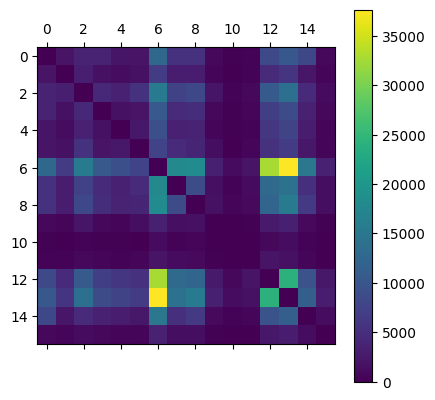

In [ ]:
razz = plt.matshow(average_correlation_over_periods)
plt.colorbar(razz)

In [ ]:
max(average_correlation_over_periods.flatten())

37663.263285081746

In [ ]:
max(symmetrized_correlation_matrices[0].flatten())

3029.7535210082233

In [ ]:
num_neurons

16

In [ ]:
np.shape(np.squeeze(firing_rates))

(16, 111971)

In [ ]:
binned_spikes_matrix_test = time_binning(longest_sleep_period,[longest_sleep_period.timestamp.min(),longest_sleep_period.timestamp.max()])

1.9561000000003332
0 16
3512.0180666666665
58


In [ ]:
np.shape(binned_spikes_matrix_test)

(1, 10, 1956)

Text(0, 0.5, 'Neuron (#)')

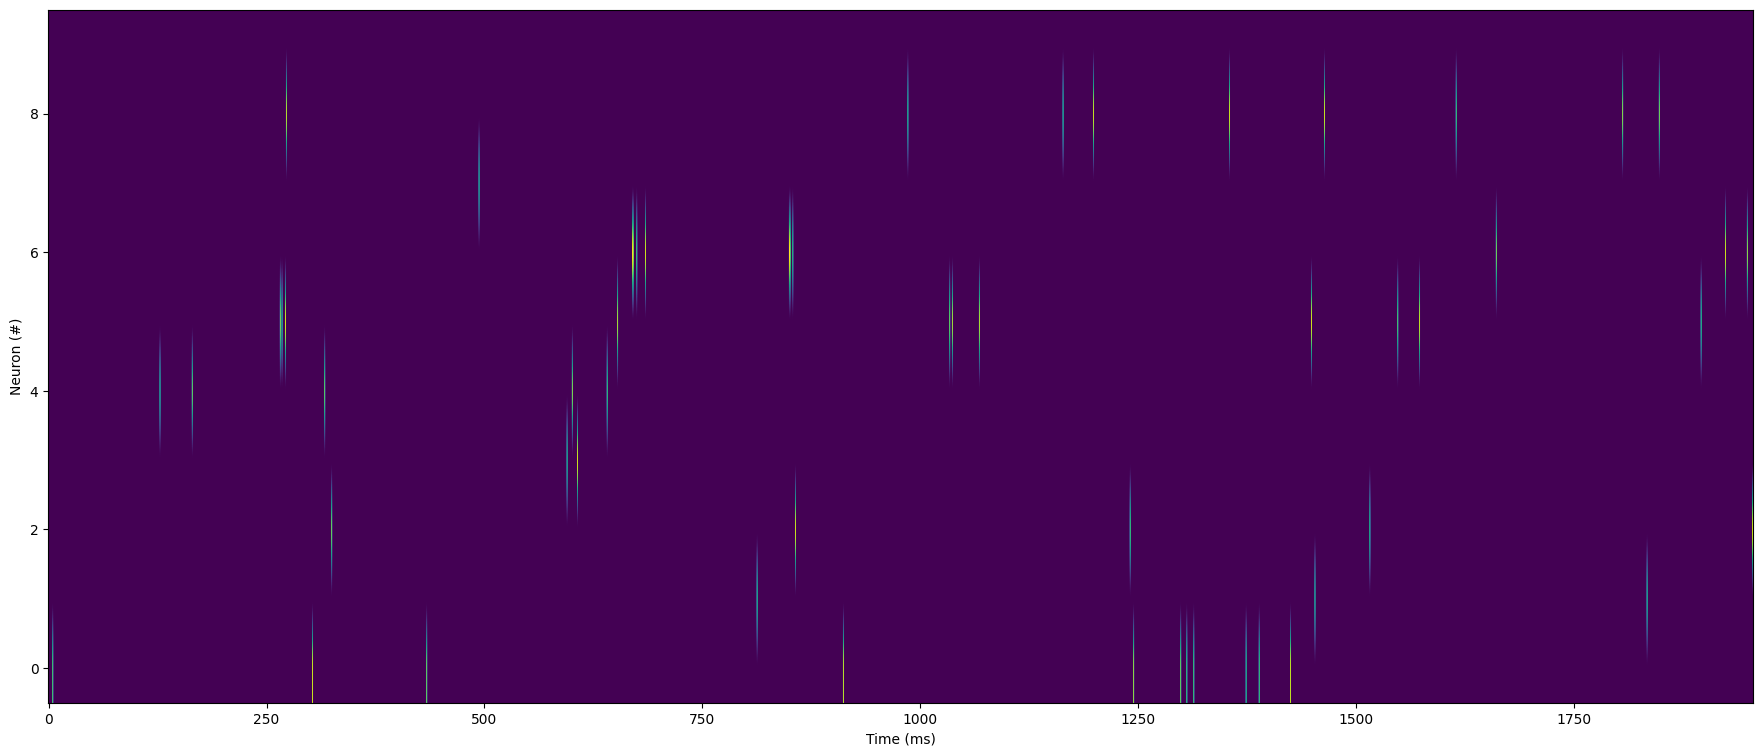

In [ ]:
fig, ax = plt.subplots(figsize=(22, 9))

rates = ax.imshow(binned_spikes_matrix_test[0,:,:],aspect='auto',origin='lower')

ax.xaxis.tick_bottom()
ax.xaxis.set_label_position('bottom')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Neuron (#)')

In [ ]:
firing_rates = convolve_raster(binned_spikes_matrix_test)

(1, 10, 1956)


Text(0, 0.5, 'Neuron (#)')

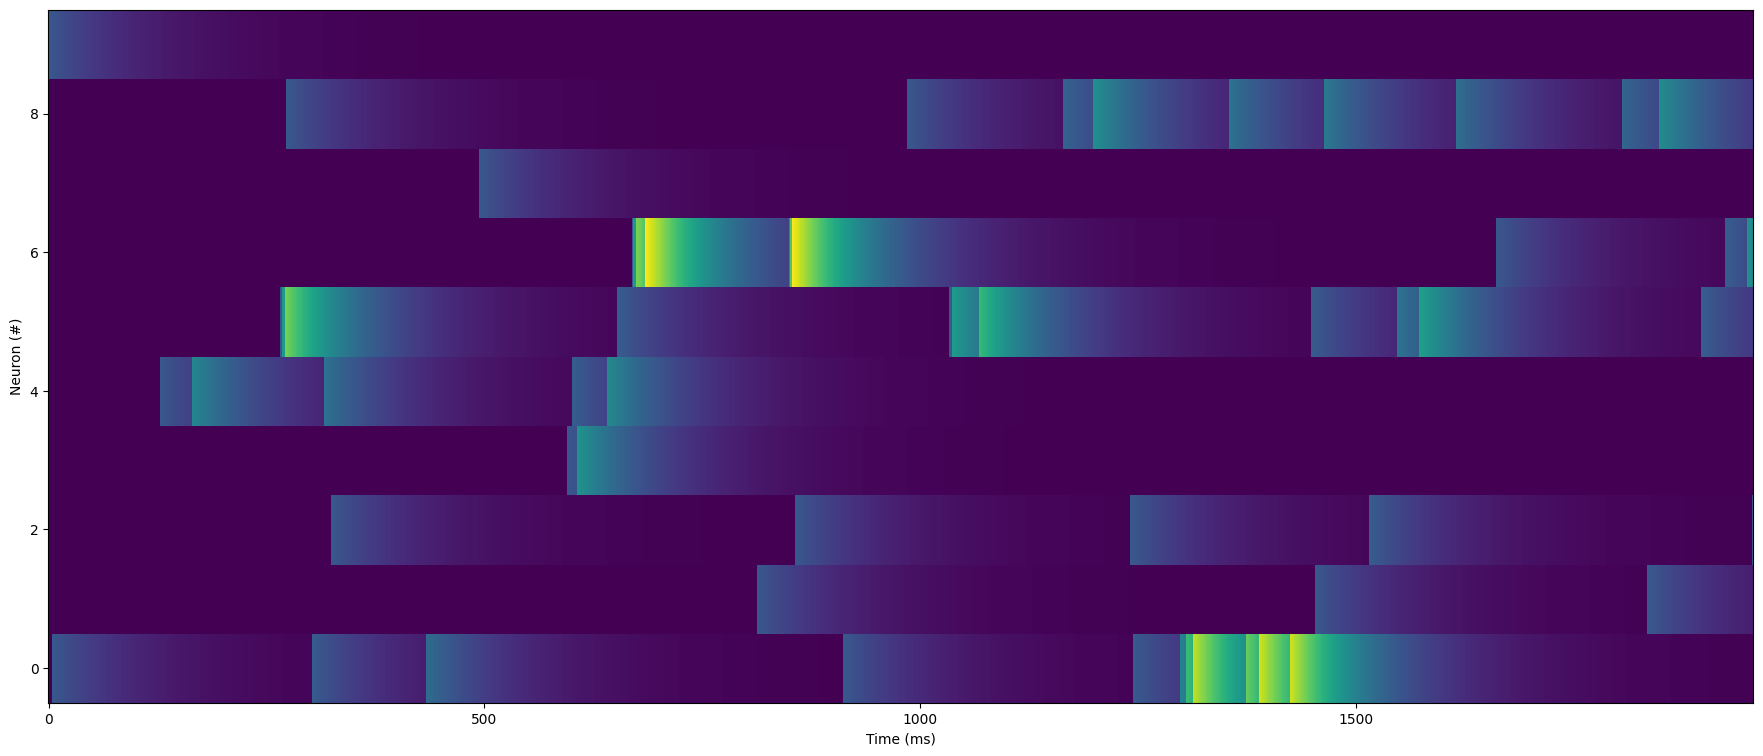

In [ ]:
fig, ax = plt.subplots(figsize=(22, 9))

rates = ax.matshow(firing_rates[0,:,:],aspect="auto",origin='lower')

ax.xaxis.tick_bottom()
ax.xaxis.set_label_position('bottom')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Neuron (#)')

In [ ]:
np.shape(firing_rates[0,:,:])

(10, 1956)

In [ ]:
from itertools import combinations

for neuron1,neuron2 in combinations(range(10),2):
  print(neuron1,neuron2)

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 4
3 5
3 6
3 7
3 8
3 9
4 5
4 6
4 7
4 8
4 9
5 6
5 7
5 8
5 9
6 7
6 8
6 9
7 8
7 9
8 9


In [ ]:
correlations_matrix = np.zeros([,10,10])

for neuron1,neuron2 in combinations(range(10),2):
  correlation_between_pair = np.correlate(firing_rates[0,neuron1,:],firing_rates[0,neuron2,:])
  correlations_matrix[neuron1,neuron2] = correlation_between_pair
  print(correlation_between_pair)

[153.86246851]
[323.49647795]
[29.12101912]
[140.15577906]
[491.75065994]
[155.80159119]
[36.24757877]
[633.39276969]
[51.05121869]
[68.8886672]
[12.09491308]
[15.50144063]
[137.72629806]
[180.42005473]
[2.06730949]
[175.85427102]
[0.]
[14.30460475]
[79.18375383]
[244.20167422]
[201.70899781]
[10.61715058]
[199.18738619]
[1.94671845]
[170.73463553]
[74.45178095]
[217.15372047]
[34.61216468]
[6.51684753]
[0.23356299]
[274.46506146]
[278.64575365]
[40.57992088]
[68.00412235]
[25.96216014]
[345.26924126]
[26.70917862]
[572.23487005]
[10.33313602]
[37.1208352]
[151.97866789]
[0.18156067]
[5.95482087]
[0.35634246]
[3.27713496]


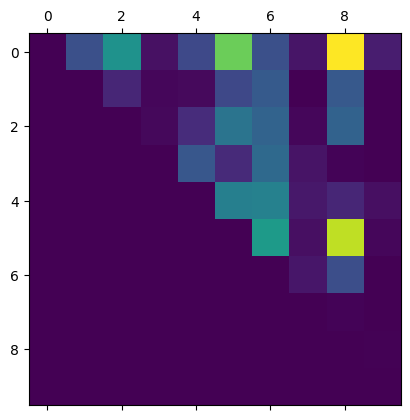

In [ ]:
plt.matshow(correlations_matrix)

In [ ]:
def symmetrize(a):
    """
    Return a symmetrized version of NumPy array a.

    Values 0 are replaced by the array value at the symmetric
    position (with respect to the diagonal), i.e. if a_ij = 0,
    then the returned array a' is such that a'_ij = a_ji.

    Diagonal values are left untouched.

    a -- square NumPy array, such that a_ij = 0 or a_ji = 0,
    for i != j.
    """
    return a + a.T - np.diag(a.diagonal())

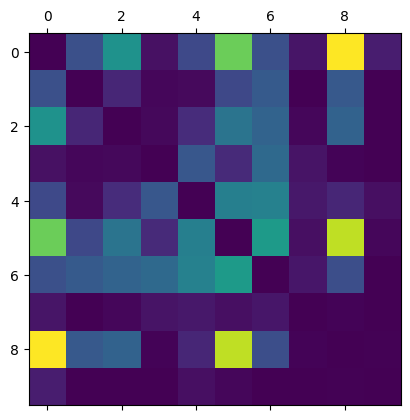

In [ ]:
plt.matshow(symmetrize(correlations_matrix))

# trying out

In [35]:
def separate_rats(dataframe,check_num_neurons=True,min_num_neurons = 2):
    #Separate the dataframe by rat, and store each part as an entry in a list

    # INPUT:
    # - dataframe
    # - check_num_neurons: check whether a rat in this dataframe has less than min_num_neurons (default: True)
    # - min_num_neurons: the least amount of neurons an animal has to have in order to be included (default: 2)

    # OUTPUT:
    # - rats: a list of DataFrames, each entry being the subset of the main DataFrame with the spikes from one rat

    rats = []
    for rat in dataframe['rat'].unique():

        #Check whether a rat has only one registered neuron in the dataset
        if check_num_neurons:
            if dataframe.loc[dataframe['rat']==rat].neuron.nunique() < min_num_neurons:
                #If it's less than min_num_neurons, skip to the next animal
                continue
            #If one's not checking (check_num_neurons = False) or the animal has sufficient neurons, save it
        rats.append(dataframe.loc[dataframe['rat'] == rat])
    return rats #an array of dataframes (!)

def estimate_sqi(binned_spikes,num_entropic_bins=15,mean_over_trials=True):

    #Estimate the Sequentiality Index (SqI) as defined in [1] for N neurons over M trials

    #Python version of the code originally written in Matlab by Dean Buonomano and Shanglin Zhou in 9/14/2019
    #Original available at: github.com/ShanglinZhou/M2_DLS_2Intervals

    # INPUT:
    # - convolved_spikes [np.ndarray (int,int,int)]: a trials x neurons x timebins matrix with the normalised firing rate (convolved & normalised spike trains) for each neuron at each trial
    # - num_entropic_bins [int]: Number of timebins to estimate the Peak Entropy. For more details check the paper. (default: 15)
    # - mean_over_trials: whether the entropic estimates (SqI, PE, TS) should be averaged over all trials (default: True, as in the original paper)

    # OUTPUT:
    # - entropic_variables [list (tuples (float)) or tuple (float)]: if mean_over_trials, a tuple of floats representing respectively the SqI, PE and TS.
                                                                  #  else, a list of tuples with these variables at each trial

    #[1] Zhou et al., Neural Sequences as an Optimal Dynamical Regime for the Readout of Time, Neuron (2020), https:// doi.org/10.1016/j.neuron.2020.08.020

    trials,num_neurons,timebins = np.shape(binned_spikes)
    binsize = timebins/(num_entropic_bins - 1)

    #To store the results
    entropic_variables = np.zeros([trials,3])

    for current_trial in range(trials):
        #Calculating the Peak Entropy (PE):

        #peak times: the time bin in which each unit reaches its greatest value
        peaktimes = np.argmax(binned_spikes[current_trial],axis=1)

        #build the entropic bins in which the peaks will be counted
        centers_arange = np.arange(start=0-binsize/2,stop=timebins+binsize/2,step=binsize)
        '''The MATLAB hist() function bins the histogram around the centers. In order to implement a version of it
        in Python using numpy's histogram() function, I had to position the leftmost edge half a binsize before 0,
        and the last one half binsize after 1500, accounting for (N+1) edges, where N is the number of intended
        bins passed in MATLAB, so that upon calculating the histogram the number of bins of these two and the
        points within each timespan would be the same'''

        #how many neurons peak per entropic bin:
        n,edges = np.histogram(np.argmax(binned_spikes[current_trial],axis=1),centers_arange)

        #the probability of peak in each bin is the number of peaks in that bin (n)
        #divided by the total number of units
        probpeak = np.divide(n,num_neurons)

        #remove non-spiking bins from calculation (they'd contribute nothing for p_j = 0,
        #but computationally would yield problems upon feeding p_j = 0 into the np.log2() function)
        probpeak = probpeak[probpeak>0]

        #sum the entropic contributions
        pe = np.sum(-probpeak*np.log2(probpeak))

        #and normalise
        pe = pe/np.log2(num_entropic_bins) #normalised peak entropy for this trial

        #Calculating the Temporal Sparsity (TS):
        #normalise each neuron's activity by the spikes of all neurons in that timebin
        #(summed values for the column with sum())
        dn = np.divide(binned_spikes[current_trial],sum(binned_spikes[current_trial]))

        '''This accounts for a "probability distribution" of sorts, for it attends to all Kolmogorov axioms:
        - All entries are non-negative;
        - No entry exceeds 1;
        - The compound entry for disjoint events (say, different neurons' activities in a timebin) equals the
        sum of individual entries for each event'''

        #sum the entropic contribution of each neuron over time in the population
        ts = np.nansum(np.multiply(-dn,np.log2(dn)),axis=0)

        #mean in the time dimension
        ts = np.mean(ts)

        #normalise by the number of neurons and subtract from 1
        ts = 1 - ts/np.log2(num_neurons)

        #the sqi is the geometric mean of these values:
        sqi = np.sqrt(pe*ts)

        entropic_variables[current_trial] = [sqi,pe,ts]

    if mean_over_trials:
      #take the mean over all trials
      sqi = np.mean(entropic_variables,axis=0)[0]
      pe = np.mean(entropic_variables,axis=0)[1]
      ts = np.mean(entropic_variables,axis=0)[2]
      return sqi,pe,ts

    else:
      return entropic_variables

def time_binning(spikes_df,timespan=[0,1.5]):

  #Transform the spikes DataFrame into a 3D np.ndarray whose dimensions are (trials,neurons,timebins)

  # INPUT:
  # - dataset [pandas DataFrame]
  # - timespan [list(float)]: the timestamp boundaries in which all spikes to be binned lie within (in s; default = [0s,1.5s])

  # OUTPUT:
  # - binned_spikes: a trials x neurons x timebins matrix

  #just in case the dataset is not sorted by trial
  dataset = spikes_df.sort_values('trial').copy()

  num_trials = dataset.trial.nunique()
  num_neurons = dataset.neuron.nunique()

  duration = timespan[1] - timespan[0]
  num_timebins = int(duration*1000)

  binned_spikes_matrix = np.zeros([num_trials,num_neurons,num_timebins])

  for trial_id,trial in enumerate(dataset.trial.unique()):
    for neuron_id,neuron in enumerate(dataset.neuron.unique()):
      spike_train = dataset.loc[(dataset['trial'] == trial) & (dataset['neuron'] == neuron)]
      discretized_spike_train,edges = np.histogram(spike_train.time,bins = np.linspace(timespan[0],timespan[1],num_timebins+1,endpoint=True))
      binned_spikes_matrix[trial_id,neuron_id,:] = discretized_spike_train

  return binned_spikes_matrix

def convolve_raster(binned_spikes):
    #Convolve a matrix containing the raster plots (time histogram of spikes) for all neurons in all trials

    #INPUT:
    # - binned_spikes: a trials x neurons x timebins matrix
    # - width: the kernel width, in ms
    # - sd: I haven't figured it out exactly yet: lower values widen the kernel shape and larger ones sharpen it
    #the authors didn't call it SD, I am extrapolating from my knowledge on gaussian filtering (might be wrong)

    #OUTPUT:
    # - convolved [np.ndarray(int,int,float)]: a trials x neurons x timebins matrix of convolved spiking activity

    x = np.linspace(0,750,750) #750 ms in 750 points

    kernel = np.exp(-x/100)
    kernel = np.pad(kernel,(750,0),'constant') #center the kernel at 0

    #uncomment these to plot the kernel
    #plt.figure()
    #plt.title('Decaying exponential kernel')
    #plt.plot(np.arange(0,len(x)),decaying_exp)

    #uncomment these to plot evidence that the kernel drops to 1/e over the course of 100ms
    #plt.figure()
    #plt.title('Decaying exponential kernel')
    #plt.plot(np.arange(0,len(x)),decaying_exp)


    #create a matrix with the same dimensions as the binned rasters' to accommodate the convolved rasters
    all_neurons_convolved = np.zeros(np.shape(binned_spikes))
    print(np.shape(all_neurons_convolved))

    #the # of trials, neurons and timebins are given by:
    trials,neurons,timebins = np.shape(binned_spikes)

    for trial in range(trials):
        for neuron in range(neurons):
            all_neurons_convolved[trial,neuron,:] = np.convolve(kernel,binned_spikes[trial,neuron,:]
                                                            ,mode='full')[750:-749]

    return all_neurons_convolved

def normalise_data(rasters):
    # Normalise the firing rates of each neuron by its maximum firing rate

    #INPUT:
    # - rasters: a convolved trials x neurons x timebins matrix

    #OUTPUT:
    # - normalised: the normalised (post-convolution) spike trains in the raster [all firing rates between 0 and 1]

    #######################################################################################################

    trials,neurons,timebins = np.shape(rasters)
    normalised = np.zeros([trials,neurons,timebins])

    for neuron in range(neurons):
        #select the neuron of interest
        current_cell = rasters[:,neuron,:]

        #get the largest and smallest firing rates this neuron has throughout the session
        minimum_fr = current_cell.min()
        maximum_fr = current_cell.max()

        #subtract the mininum fr from all cells and normalised by the greatest difference between firing rates
        normalised_cell = (current_cell - minimum_fr)/(maximum_fr - minimum_fr)

        #just in case of the firing rate being always the same and we try to divide by zero:
        normalised_cell[np.isnan(normalised_cell)] = 0

        #save it onto the matrix
        normalised[:,neuron,:] = normalised_cell

    return normalised

def least_amount_neurons(dataset,num_cells_threshold = 4):
    #Drop trials with less than a given amount of neurons out of the dataset and find the least amount of units among all remaining trials that is not below this threshold

    #INPUT:
    # - dataset: pandas DataFrame [pd.df] (for columns and descriptions: see _specifications_)
    # - num_cells_threshold: the least amount of neurons required for inclusion of that trial

    #OUTPUT:
    # - pruned_dataset: the dataset (pd.df) cleared of the data pertaining to trials with less neurons than needed
    # - min_num_units: the minimum number of neurons all the remaining cells possess

    #Make a copy, so it'll not alter the given dataset
    pruned_dataset = dataset.copy()

    #Set the minimum amount of neurons to a high initial value
    min_num_units = 10_000 #a ludicrous amount of neurons

    #Check each trial for their number of neurons
    for trial in dataset.trial.unique():
        #if it falls below the threshold, remove it from the pruned_dataset
        if dataset.loc[dataset['trial'] == trial].neuron.nunique() < num_cells_threshold:
            pruned_dataset.drop(pruned_dataset.loc[pruned_dataset['trial']==trial].index,inplace=True)
            pass #skip to the next trial, so not to alter min_num_units with this trial

        #if it is not lower than this least amount, check if it is less than what was set to be the minimum so far
        elif dataset.loc[dataset['trial'] == trial].neuron.nunique() < min_num_units:
            min_num_units = dataset.loc[dataset['trial'] == trial].neuron.nunique()

    return pruned_dataset,min_num_units

def least_amount_spikes(dataset,num_spikes_threshold = 4):
    #Drop trials with less than a given amount of spikes out of the dataset

    #INPUT:
    # - dataset: pandas DataFrame [pd.df] (for columns and descriptions: see _specifications_)
    # - num_spikes_threshold: the least amount of neurons required for inclusion of that trial

    #OUTPUT:
    # - pruned_dataset: the dataset (pd.df) cleared of the data pertaining to trials with less spikes than required

    #Make a copy, so it'll not alter the given dataset
    pruned_dataset = dataset.copy()

    #Check each trial for their number of neurons
    for trial in dataset.trial.unique():
        #if it falls below the threshold, remove it from the pruned_dataset
        if len(dataset.loc[dataset['trial'] == trial]) < num_spikes_threshold:
            pruned_dataset.drop(pruned_dataset.loc[pruned_dataset['trial']==trial].index,inplace=True)

    return pruned_dataset

In [36]:
def early_late_entropic_vars_per_rat(separated_rats,group,day,region,num_bins = 15,interest_variable = 'all'):
  if interest_variable == 'sqi':
    position = 0
  elif interest_variable == 'pe':
    position = 1
  elif interest_variable == 'ts':
    position = 2
  elif interest_variable == 'all':
    position = None
  else:
    raise ValueError('Choose a SqI variable out of the following three: "sqi", "pe" or "ts". If all three, pass in "all"')

  entropic_results_early = []
  entropic_results_late = []
  rats_ids = []

  least_amount_of_trials = min([animal.trial.nunique() for animal in separated_rats])
  trials_in_thirds = int(least_amount_of_trials/3)

  for animal in separated_rats:
      #Get the animal's label to later identify it in the DataFrame
      animal_label = animal.rat.unique()[0]
      print('Beginning the analyses for the rat: ',animal_label)

      animal_pruned = least_amount_spikes(animal,num_spikes_threshold=5)
      current_num_neurons = animal_pruned.neuron.nunique()

      print(animal_pruned.trial.nunique())

      binned_spikes = time_binning(animal_pruned)
      convolved_spikes = convolve_raster(binned_spikes)

      #here, change the normalization for a z-scoring
      norm_first_mean_convolved = normalise_data(np.expand_dims(np.mean(convolved_spikes[0:trials_in_thirds,:,:],axis=0),axis=0))
      norm_last_mean_convolved = normalise_data(np.expand_dims(np.mean(convolved_spikes[-trials_in_thirds:,:,:],axis=0),axis=0))

      #here, define a new function that takes in a matrix and return the eigenvalues of its covariance matrix
      entropic_vars_early = estimate_sqi(norm_first_mean_convolved,num_entropic_bins = num_bins,mean_over_trials = False)[0][position]
      entropic_vars_late = estimate_sqi(norm_last_mean_convolved,num_entropic_bins = num_bins,mean_over_trials = False)[0][position]

      print(estimate_sqi(norm_first_mean_convolved))
      print(estimate_sqi(norm_last_mean_convolved))

      entropic_results_early.append(entropic_vars_early)
      entropic_results_late.append(entropic_vars_late)

      rats_ids.append(animal_label)

  early_tags = ['early' for i in range(len(separated_rats))]
  late_tags = ['late' for i in range(len(separated_rats))]

  all_tags = early_tags+late_tags

  if interest_variable == "all":
    print(entropic_results_early)
    sqis = ([element[0][0] for element in entropic_results_early] + [element[0][0] for element in entropic_results_late])
    pes = ([element[0][1] for element in entropic_results_early] + [element[0][1] for element in entropic_results_late])
    tss = ([element[0][2] for element in entropic_results_early] + [element[0][2] for element in entropic_results_late])

    df = pd.DataFrame({'sqi':sqis,'pe':pes,'ts':tss,'animal_id':rats_ids*2,'session_part':all_tags,'group':group,'day':day,'region':region})

  else:
    df = pd.DataFrame({interest_variable:entropic_results_early+entropic_results_late,'animal_id':rats_ids*2,'session_part':all_tags,'group':group,'day':day,'region':region})

  return df

In [37]:
def query_session(spikes_dataframe,group,day,region,filter_trials_between=[1.5,3.5],peri_trial_interval=-0.5):
  data_subset = spikes_dataframe.query(f'group == {group} and day == {day} and region == "{region}" and duration >= {filter_trials_between[0]} and duration <= {filter_trials_between[1]}' +
                                       f'and time >= {peri_trial_interval} and time <= {filter_trials_between[0]}').copy()

  return data_subset

######## Group 1, day 1 ###########

separated_rats = separate_rats(query_session(data,group=1,day=1,region='PFC'),check_num_neurons=True,min_num_neurons = 4)
g1d1_PFC = early_late_entropic_vars_per_rat(separated_rats,group=1,region='PFC',day=1,interest_variable='all')

######## Group 2, day 1 ###########
separated_rats = separate_rats(query_session(data,group=2,day=1,region='PFC'),check_num_neurons=True,min_num_neurons = 4)
g2d1_PFC = early_late_entropic_vars_per_rat(separated_rats,group=2,region='PFC',day=1,interest_variable='all')

separated_rats = separate_rats(query_session(data,group=2,day=1,region='STR'),check_num_neurons=True,min_num_neurons = 4)
g2d1_STR = early_late_entropic_vars_per_rat(separated_rats,group=2,region='STR',day=1,interest_variable='all')


######## Group 2, day 2 ###########
separated_rats = separate_rats(query_session(data,group=2,day=2,region='PFC'),check_num_neurons=True,min_num_neurons = 4)
g2d2_PFC = early_late_entropic_vars_per_rat(separated_rats,group=2,region='PFC',day=2,interest_variable='all')

separated_rats = separate_rats(query_session(data,group=2,day=2,region='STR'),check_num_neurons=True,min_num_neurons = 4)
g2d2_STR = early_late_entropic_vars_per_rat(separated_rats,group=2,region='STR',day=2,interest_variable='all')

Beginning the analyses for the rat:  7
603
(603, 17, 1500)


<ipython-input-35-283a9c279659>:91: RuntimeWarning: divide by zero encountered in log2
  ts = np.nansum(np.multiply(-dn,np.log2(dn)),axis=0)
<ipython-input-35-283a9c279659>:91: RuntimeWarning: invalid value encountered in multiply
  ts = np.nansum(np.multiply(-dn,np.log2(dn)),axis=0)


(0.06037742539092347, 0.4431554933063703, 0.008226082158291792)
(0.06320563668114085, 0.6621347021858165, 0.006033443791845339)
Beginning the analyses for the rat:  8
407


KeyboardInterrupt: ignored

In [ ]:
both_days_both_regions_df = pd.concat([g1d1_PFC,g2d1_PFC,g2d1_STR,g2d2_PFC,g2d2_STR])